In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/home/youlee/n24news/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = '/home/youlee/n24news/n24news/captions_and_labels.csv'
data = pd.read_csv(file_path)

groups = [
    ['Opinion', 'Food', 'Movies'],
    ['Art & Design', 'Science', 'Fashion & Style'],
    ['Television', 'Sports', 'Style'],
    ['Music', 'Health', 'Dance'],
    ['Real Estate', 'Books', 'Media'],
    ['Travel', 'Theater', 'Technology']
]

output_paths = []
for i, group_labels in enumerate(groups, 1):
    group_data = data[data['Label'].isin(group_labels)]
    output_path = f'/home/youlee/n24news/n24news/regroup_{i}.csv'
    group_data.to_csv(output_path, index=False)
    output_paths.append(output_path)

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

def tokenize_data(df):
    input_ids = []

    df['Caption'] = df['Caption'].astype(str).fillna("")

    for text in df['Caption']:
        encoded = tokenizer(
            text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze(0))
    return torch.stack(input_ids)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'labels': self.labels[idx]
        }

In [5]:
class PerceiverBlock(nn.Module):
    """
    - 크로스 어텐션 (latents -> x)
    - 이어서 셀프 어텐션 (latent들끼리)
    - 보통은 LayerNorm, MLP(FeedForward) 등을 곁들여 잔차 연결(residual branch)을 구성
    """
    def __init__(self, latent_dim, n_heads=8, self_attn_layers=1):
        super().__init__()
        # 크로스 어텐션
        self.cross_attn = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=n_heads)
        self.cross_ln = nn.LayerNorm(latent_dim)  # Layer Normalization

        # 여러 층의 셀프 어텐션
        self.self_attn_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=latent_dim, nhead=n_heads)
            for _ in range(self_attn_layers)
        ])

    def forward(self, latents, x):
        # latents, x: (T, B, dim) 형태로 가정
        # Perceiver 원리상 latents는 query, x는 key/value

        # 1) 크로스 어텐션
        updated_latents, _ = self.cross_attn(latents, x, x)
        latents = latents + updated_latents        # 잔차 연결
        latents = self.cross_ln(latents)           # LayerNorm

        # 2) 셀프 어텐션 반복
        for layer in self.self_attn_layers:
            latents = layer(latents)  # 내부적으로 잔차 연결 및 LayerNorm 포함

        return latents

class Perceiver(nn.Module):
    def __init__(self, input_dim, latent_dim, latent_size, num_classes,
                 num_blocks, self_attn_layers_per_block=1):
        super().__init__()
        self.latents = nn.Parameter(torch.randn(latent_size, latent_dim))
        self.input_projection = nn.Linear(input_dim, latent_dim)

        # 여러 개의 PerceiverBlock을 쌓음
        self.blocks = nn.ModuleList([
            PerceiverBlock(
                latent_dim=latent_dim,
                n_heads=8,
                self_attn_layers=self_attn_layers_per_block
            )
            for _ in range(num_blocks)
        ])

        self.output_layer = nn.Linear(latent_dim, num_classes)

    def forward(self, x):
        """
        x: (B, T, F) = (배치, 시퀀스 길이, 피처 차원)
        """
        B, T, F = x.size()
        x = self.input_projection(x)                 # (B, T, latent_dim)

        # latents: (latent_size, latent_dim) -> 배치 차원 확장 (B, latent_size, latent_dim)
        latents = self.latents.unsqueeze(0).expand(B, -1, -1)

        # MultiHeadAttention은 (T, B, dim) 순서를 권장하므로 permute
        x = x.permute(1, 0, 2)        # (T, B, latent_dim)
        latents = latents.permute(1, 0, 2)  # (latent_size, B, latent_dim)

        # PerceiverBlock을 여러 번 반복
        for block in self.blocks:
            latents = block(latents, x)

        # 최종 latents: (latent_size, B, latent_dim)
        latents = latents.permute(1, 0, 2).mean(dim=1)  # (B, latent_dim)
        return self.output_layer(latents)

class CombinedModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, perceiver_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.perceiver = perceiver_model

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids)  # (B, T, embed_dim)
        return self.perceiver(embeddings)       # Perceiver에 전달


In [6]:
class PackNet(nn.Module):
    def __init__(self, model):
        super(PackNet, self).__init__()
        self.model = model
        self.masks = {}
        self.current_task = None

    def set_task(self, task_id):
        self.current_task = task_id
        if task_id not in self.masks:
            self.masks[task_id] = {
                name: torch.ones_like(param, device=param.device)
                for name, param in self.model.named_parameters()
                if param.requires_grad
            }

    def prune(self, sparsity=0.2):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                mask = self.masks[self.current_task][name]
                threshold = torch.quantile(param.abs(), sparsity)
                mask[param.abs() < threshold] = 0
                self.masks[self.current_task][name] = mask

    def forward(self, input_ids, **kwargs):
        if self.current_task in self.masks:
            with torch.no_grad():
                for name, param in self.model.named_parameters():
                    if param.requires_grad:
                        param.data *= self.masks[self.current_task][name]
        return self.model(input_ids, **kwargs)

In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(dataloader), correct / total

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_loss / len(dataloader), correct / total


In [8]:
EPOCHS = 15
BATCH_SIZE = 32
K_FOLDS = 5
EMBED_DIM = 128  
LATENT_DIM = 64
LATENT_SIZE = 64
NUM_BLOCKS = 4


Group 1 처리 중...

  Fold 1/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.0972, Test Accuracy: 0.3537
epoch 1/15: train loss 1.0986, train acc 0.3694
                         test loss 1.0491, test acc 0.4313
epoch 5/15: train loss 0.5018, train acc 0.8104
                         test loss 0.4998, test acc 0.8079
epoch 10/15: train loss 0.3658, train acc 0.8713
                         test loss 0.4392, test acc 0.8363
epoch 15/15: train loss 0.3098, train acc 0.8917
                         test loss 0.4201, test acc 0.8481
Pruning 적용 중...
Pruning 이후 성능:
  Test Loss: 0.4613, Test Accuracy: 0.8301

  Fold 2/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1126, Test Accuracy: 0.3324
epoch 1/15: train loss 1.1143, train acc 0.3417
                         test loss 1.0828, test acc 0.3914
epoch 5/15: train loss 0.5207, train acc 0.8028
                         test loss 0.4794, test acc 0.8237
epoch 10/15: train loss 0.3580, train acc 0.8720
                         test loss 0.4194, test acc 0.8480
e

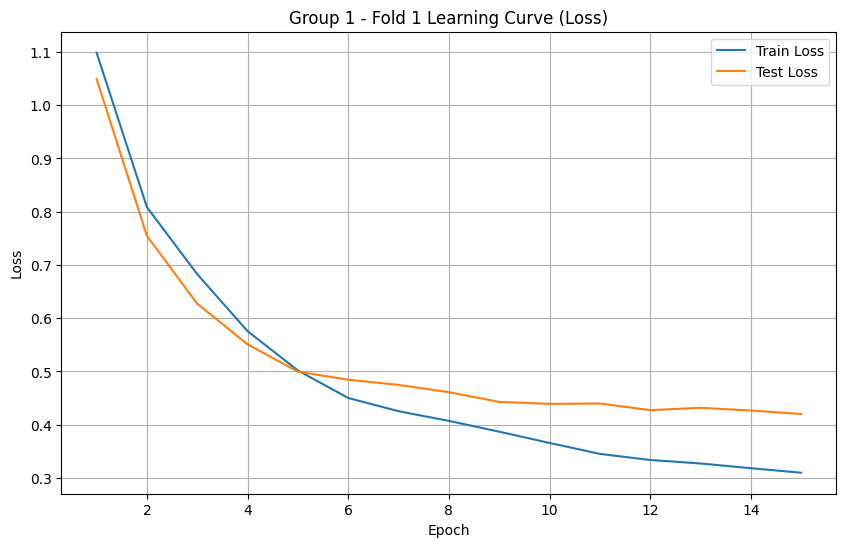

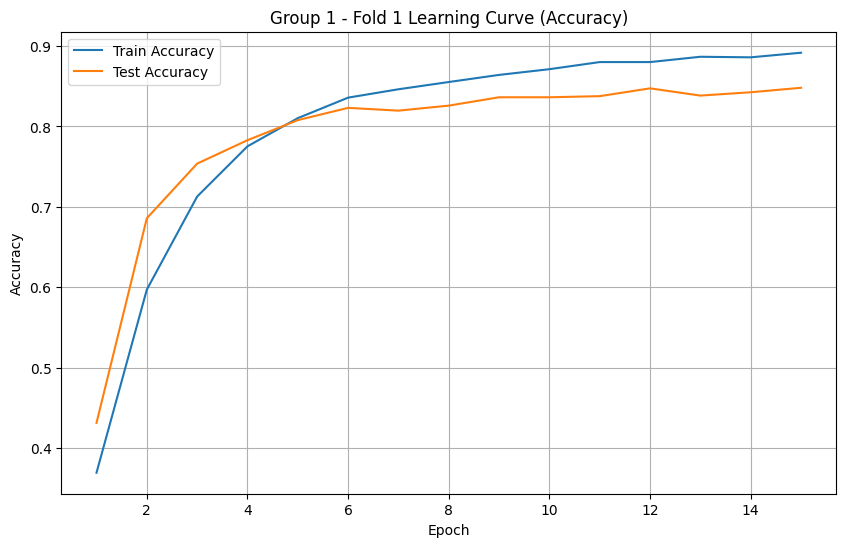

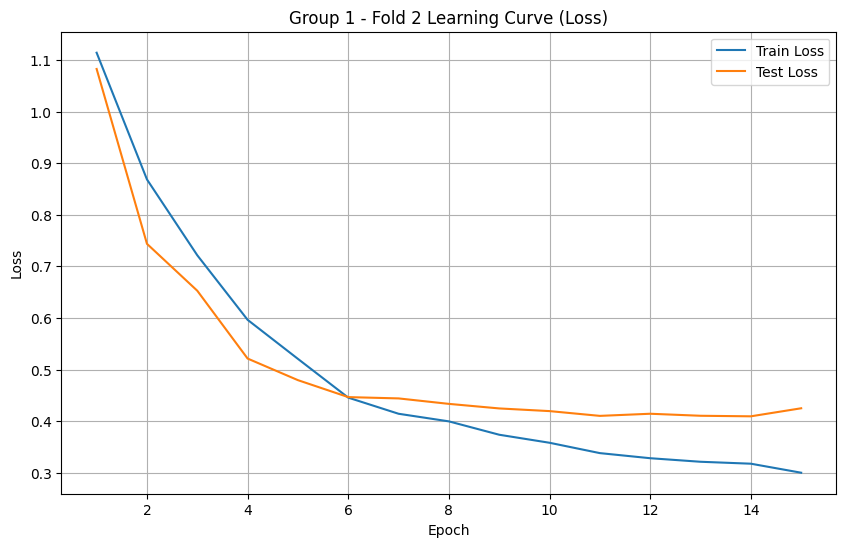

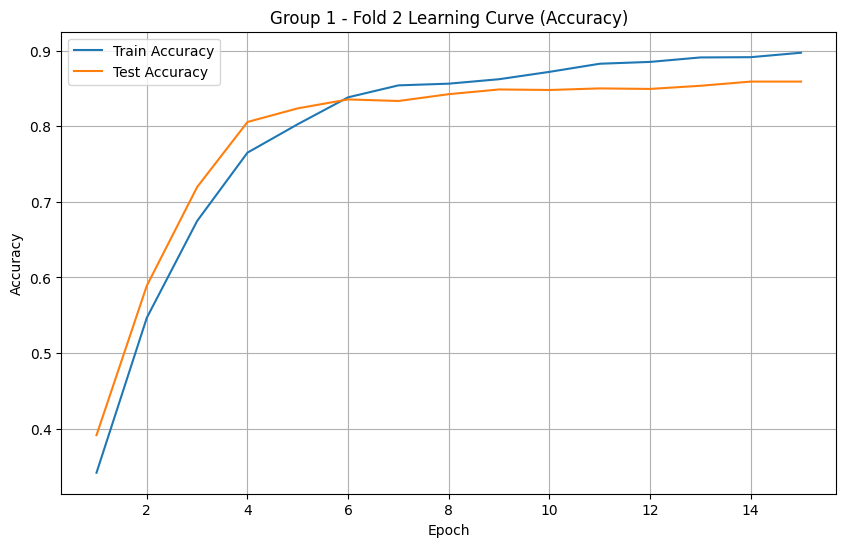

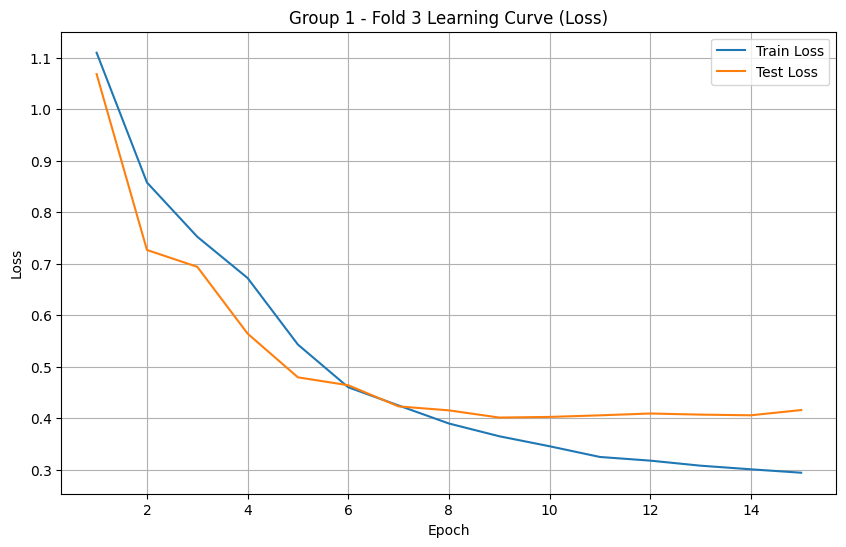

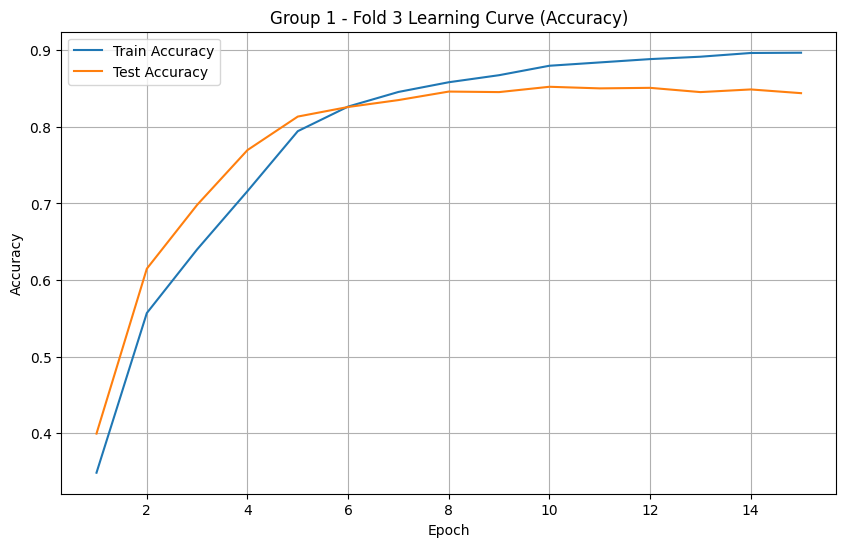

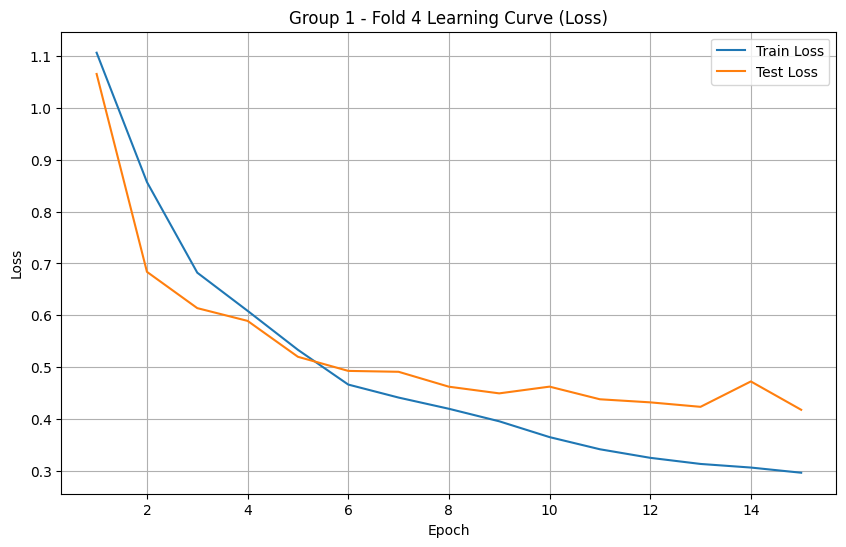

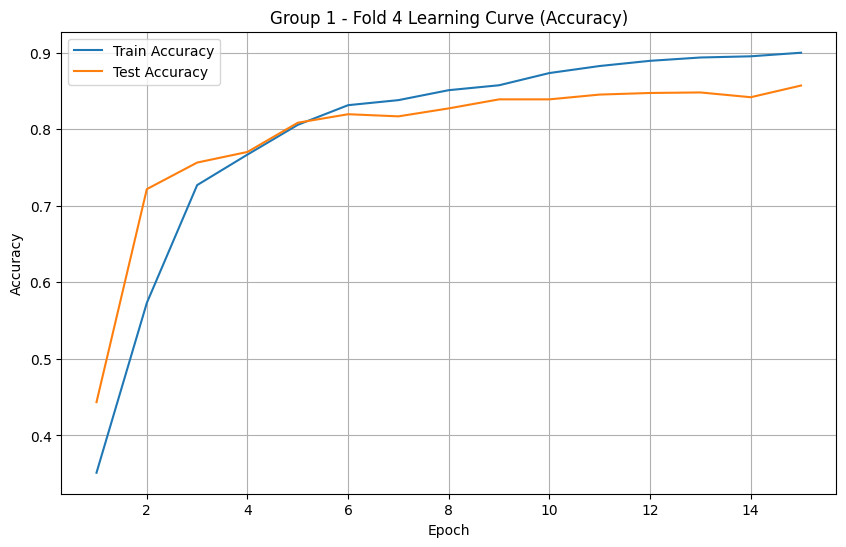

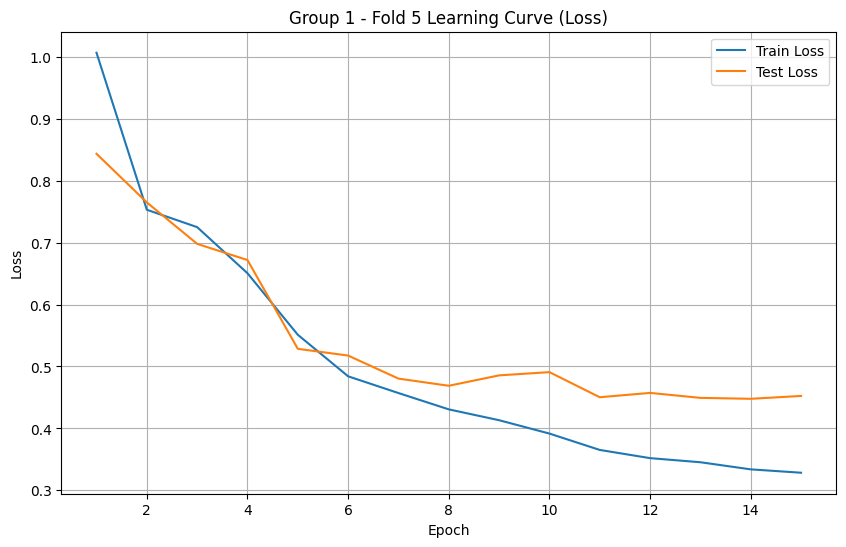

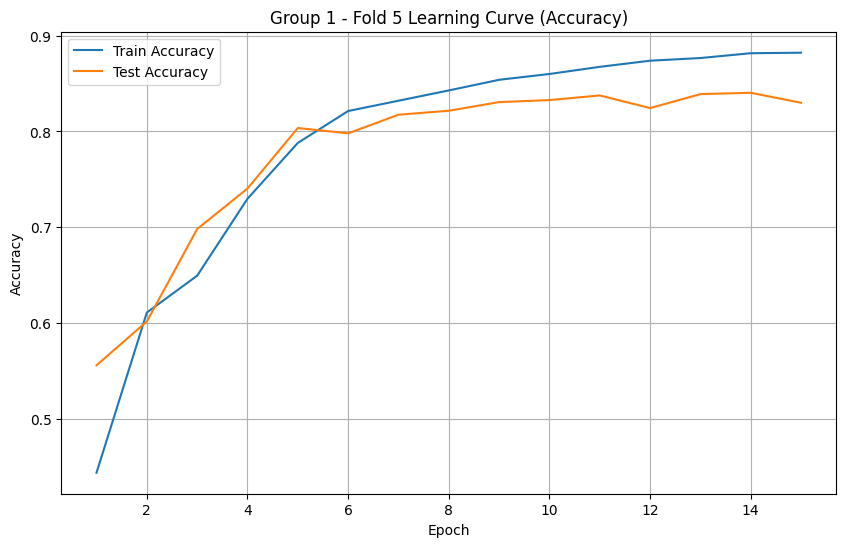

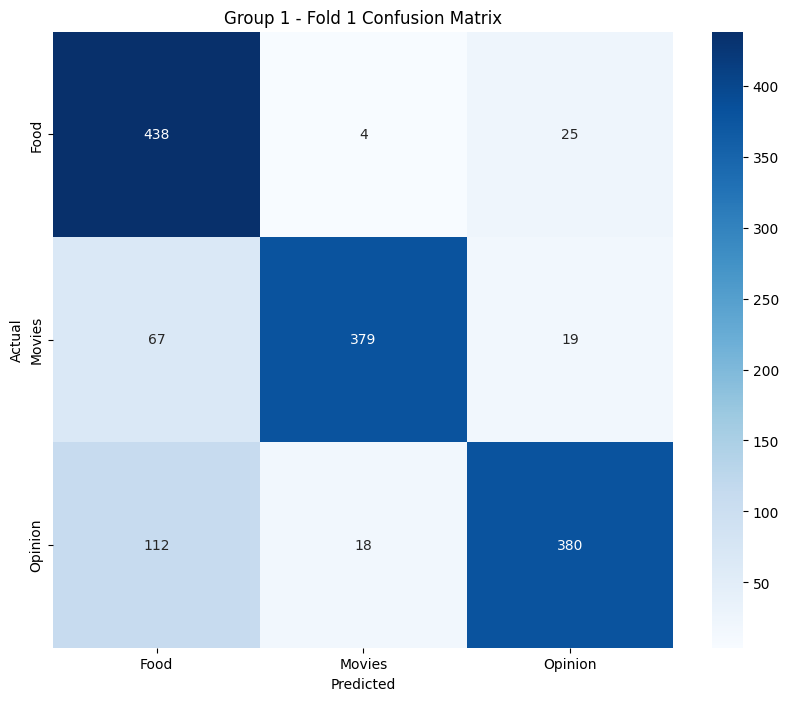

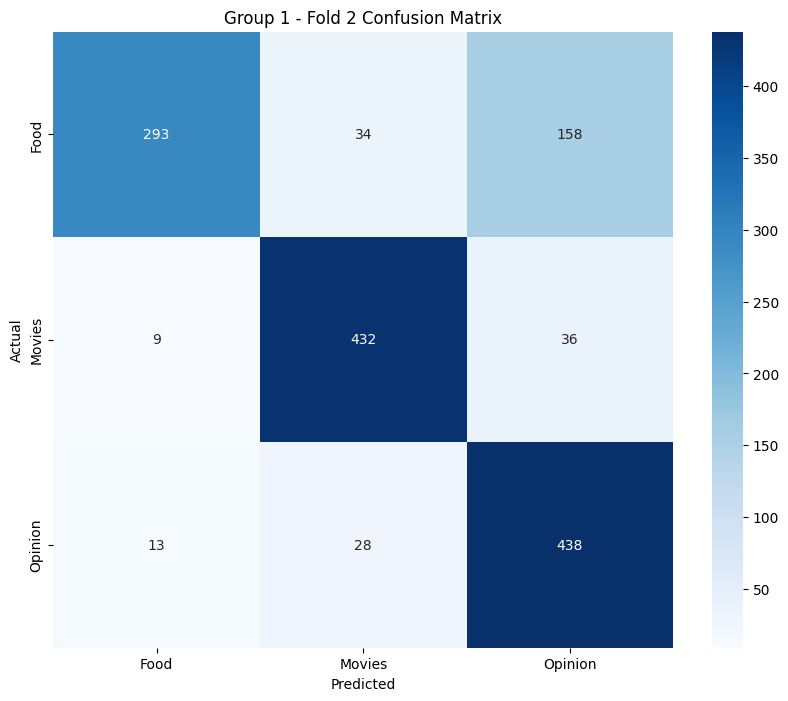

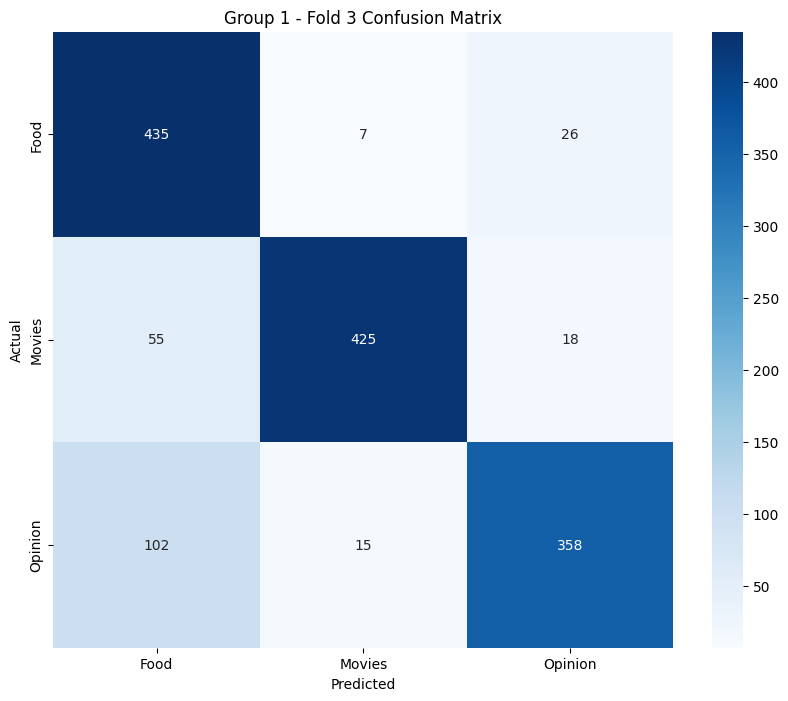

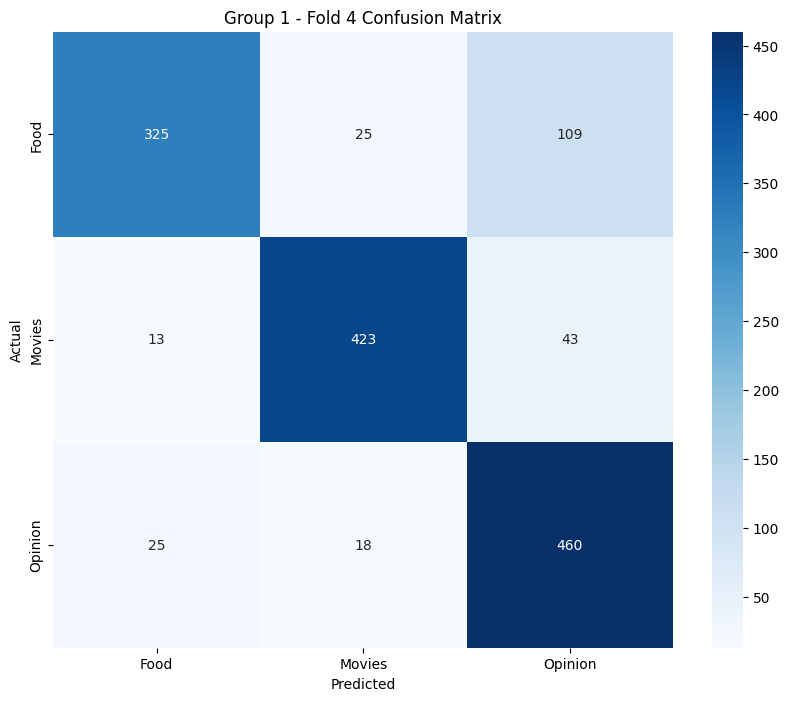

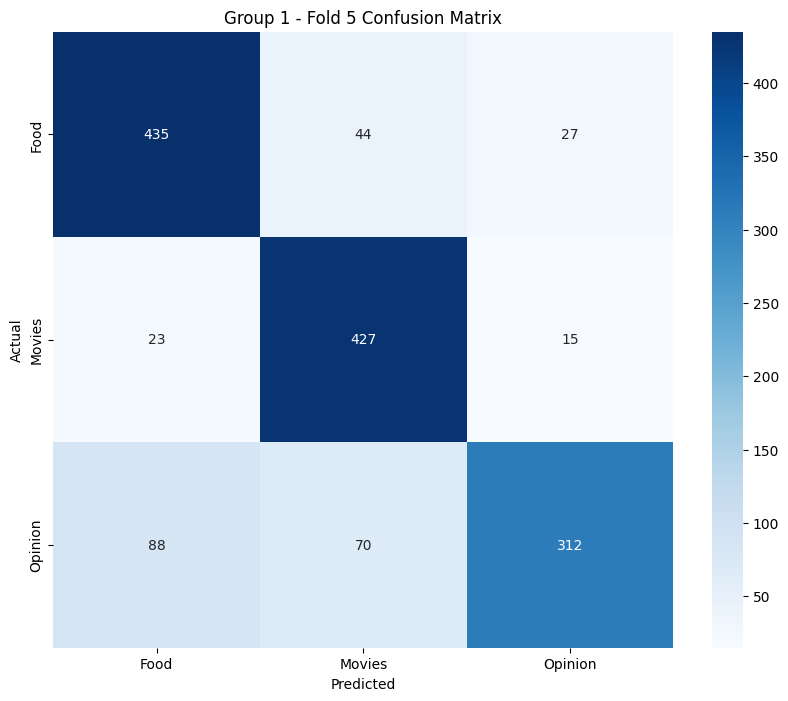


Group 2 처리 중...

  Fold 1/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.0990, Test Accuracy: 0.3442
epoch 1/15: train loss 1.0693, train acc 0.4124
                         test loss 1.0297, test acc 0.4573
epoch 5/15: train loss 0.7697, train acc 0.6704
                         test loss 0.7178, test acc 0.7002
epoch 10/15: train loss 0.5427, train acc 0.7812
                         test loss 0.5920, test acc 0.7710
epoch 15/15: train loss 0.4669, train acc 0.8186
                         test loss 0.5202, test acc 0.7994
Pruning 적용 중...
Pruning 이후 성능:
  Test Loss: 0.5447, Test Accuracy: 0.7807

  Fold 2/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1017, Test Accuracy: 0.3366
epoch 1/15: train loss 1.0840, train acc 0.3940
                         test loss 1.0393, test acc 0.4136
epoch 5/15: train loss 0.7252, train acc 0.7051
                         test loss 0.7697, test acc 0.6808
epoch 10/15: train loss 0.5559, train acc 0.7869
                         test loss 0.6315, test acc 0.7453
e

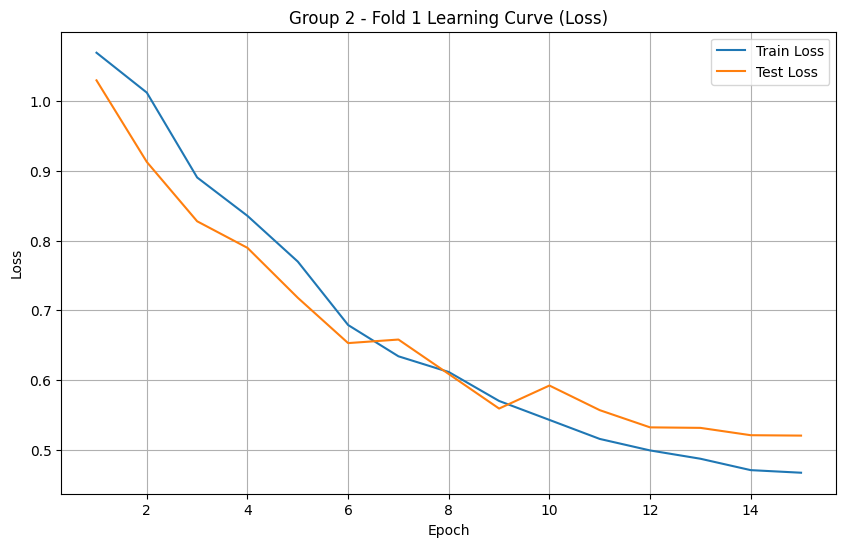

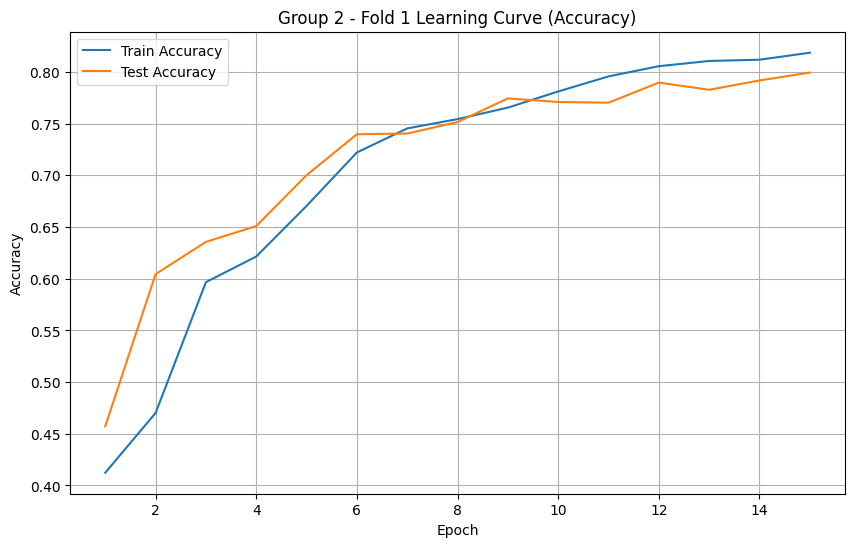

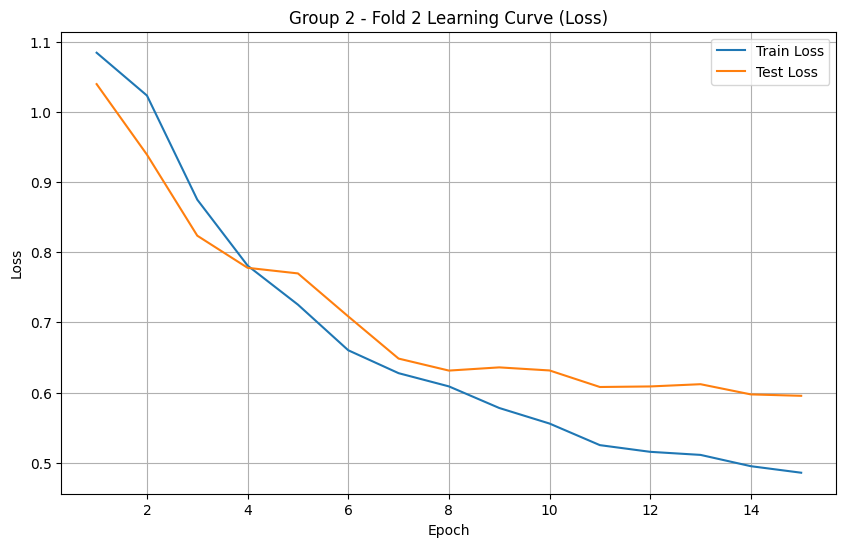

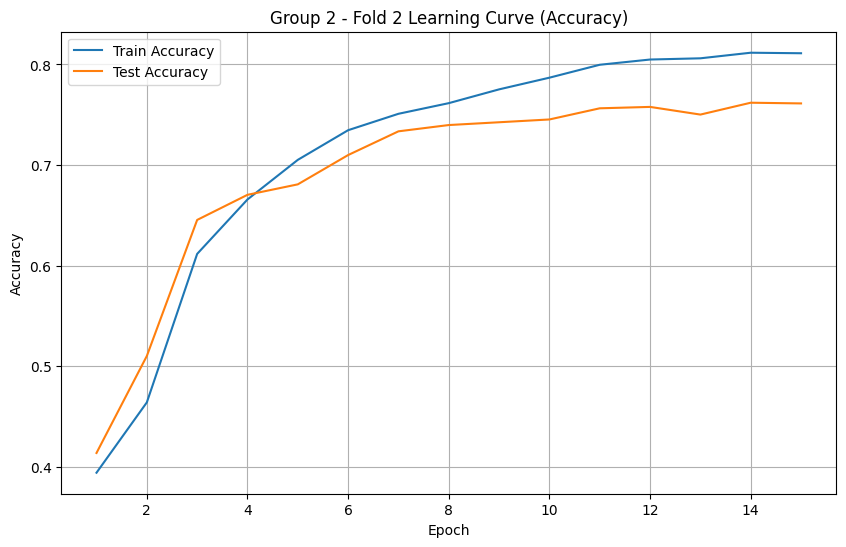

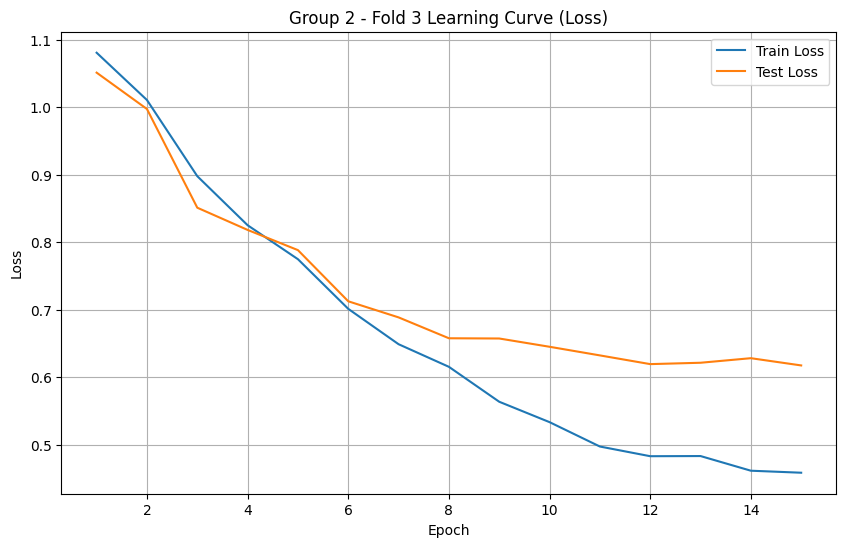

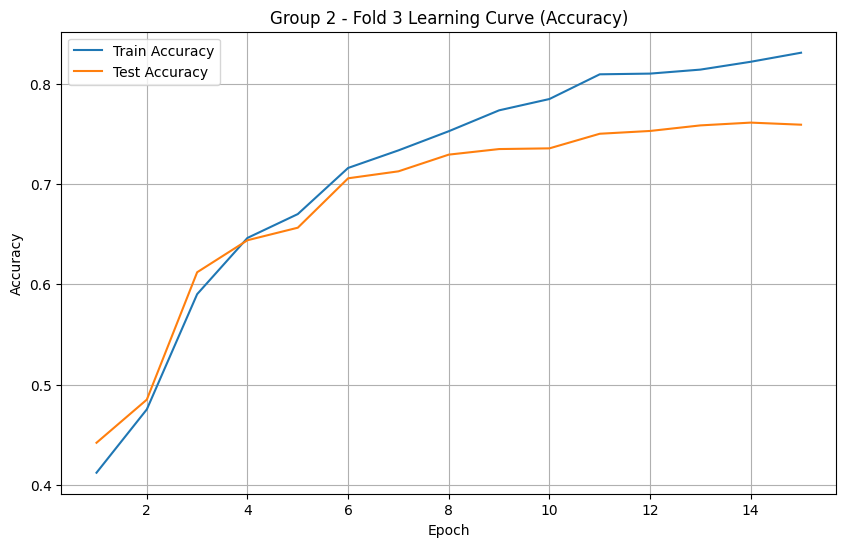

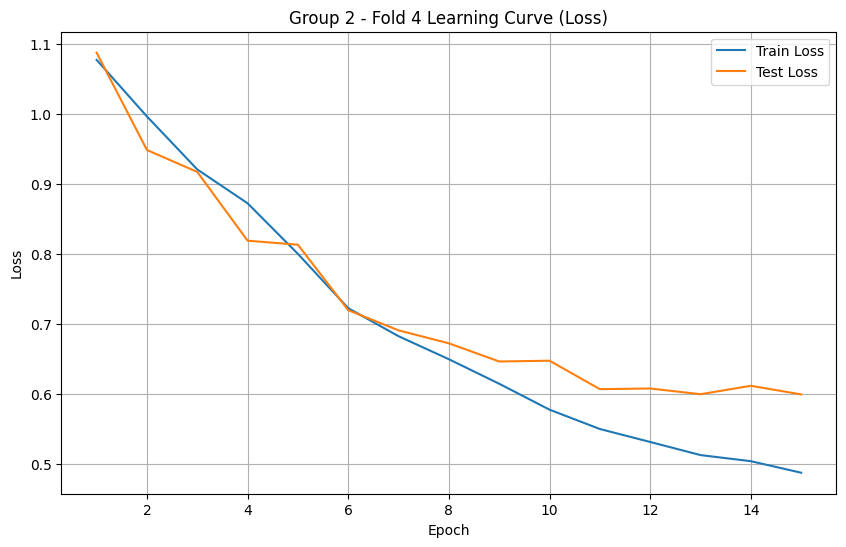

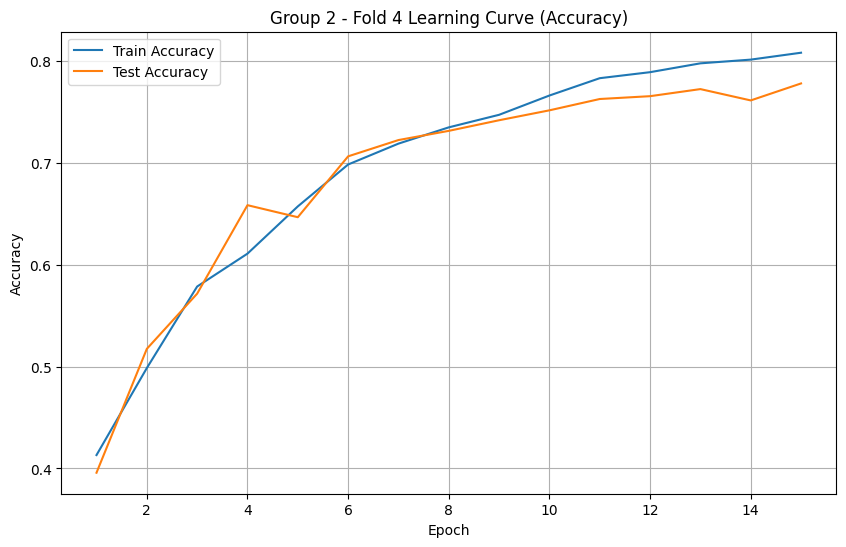

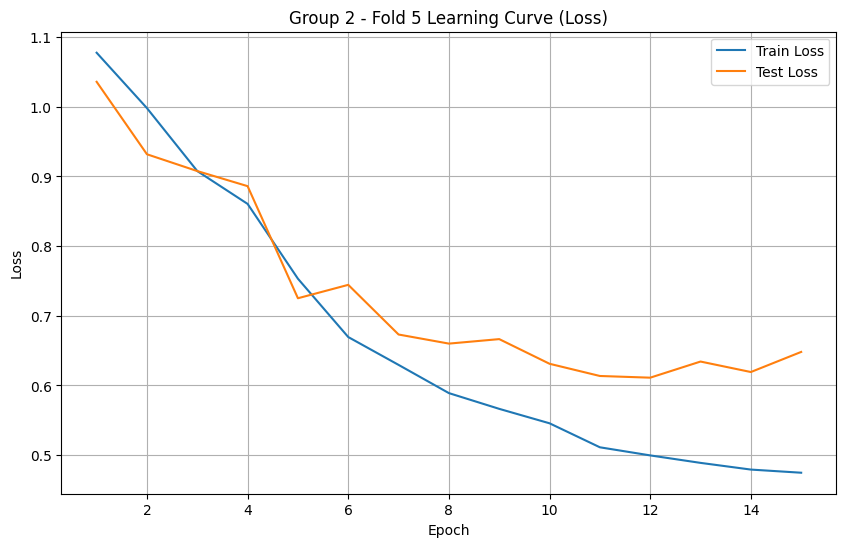

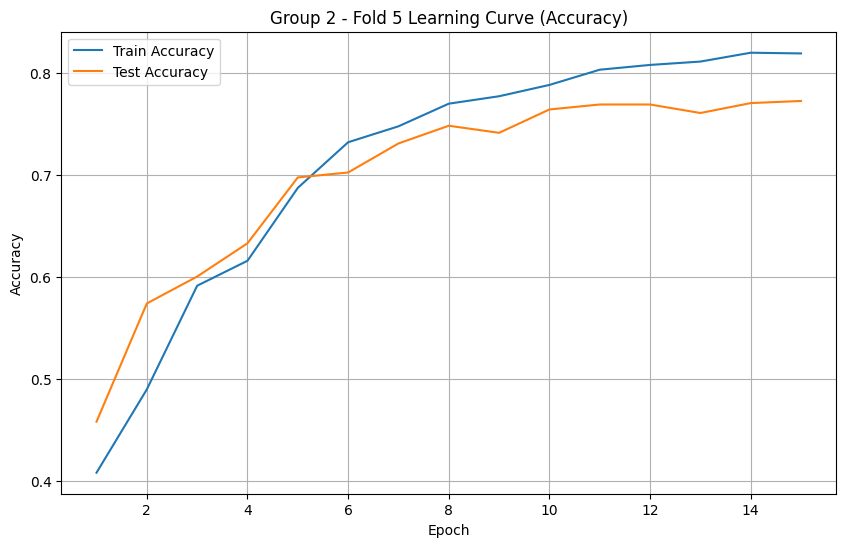

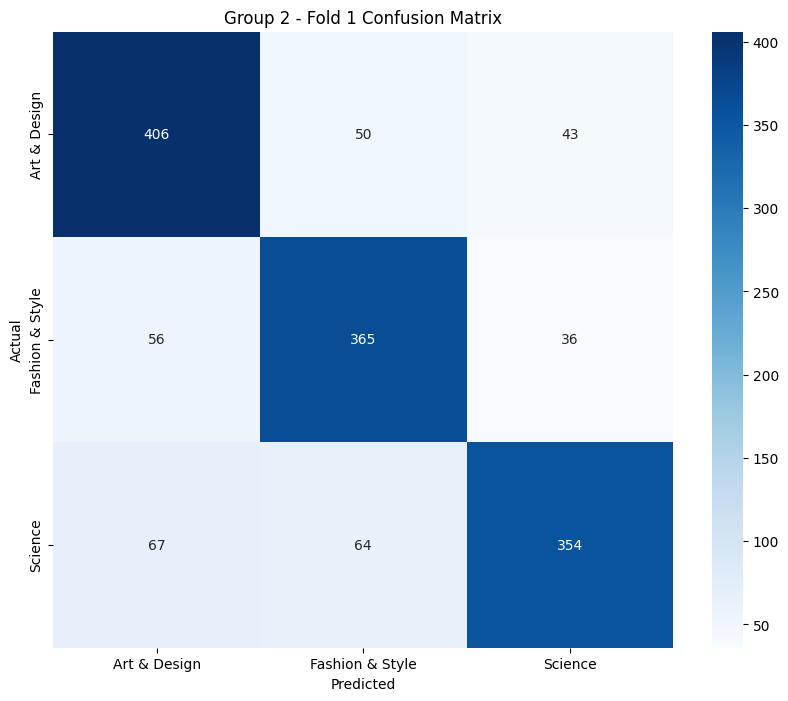

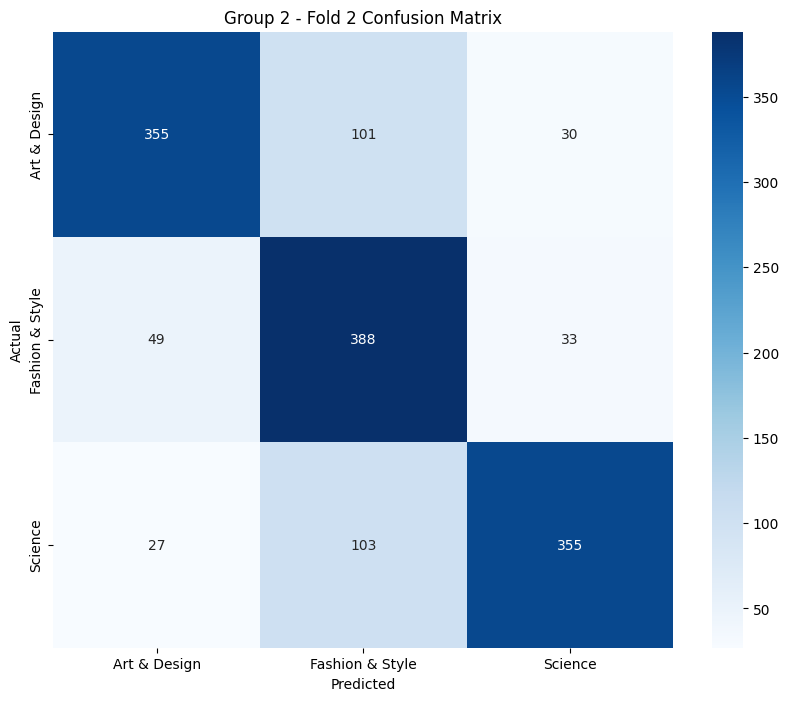

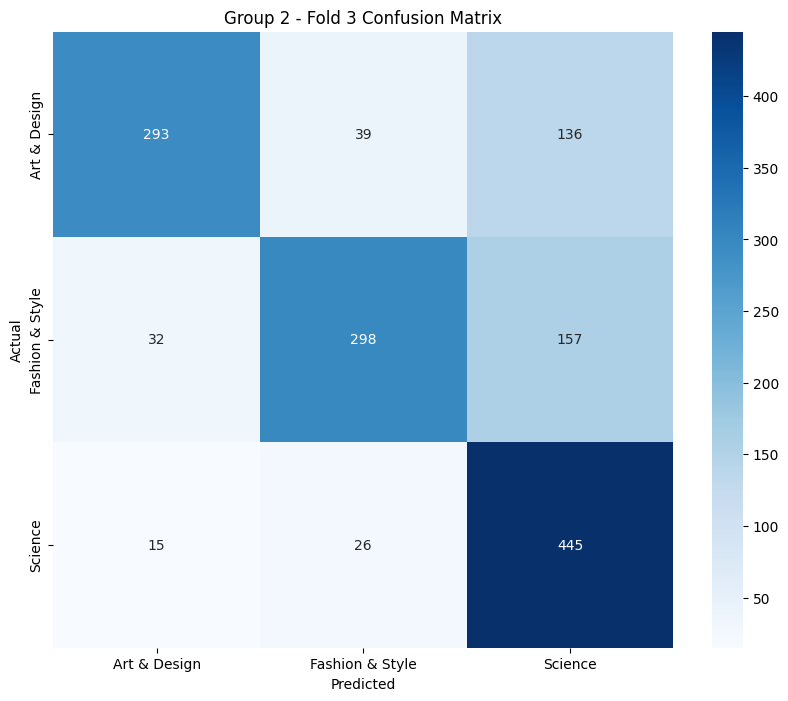

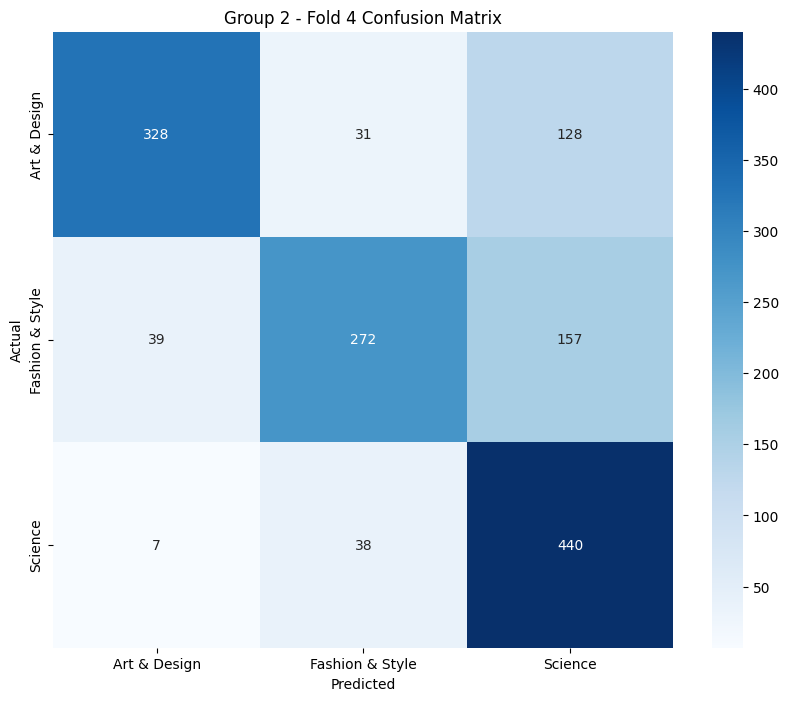

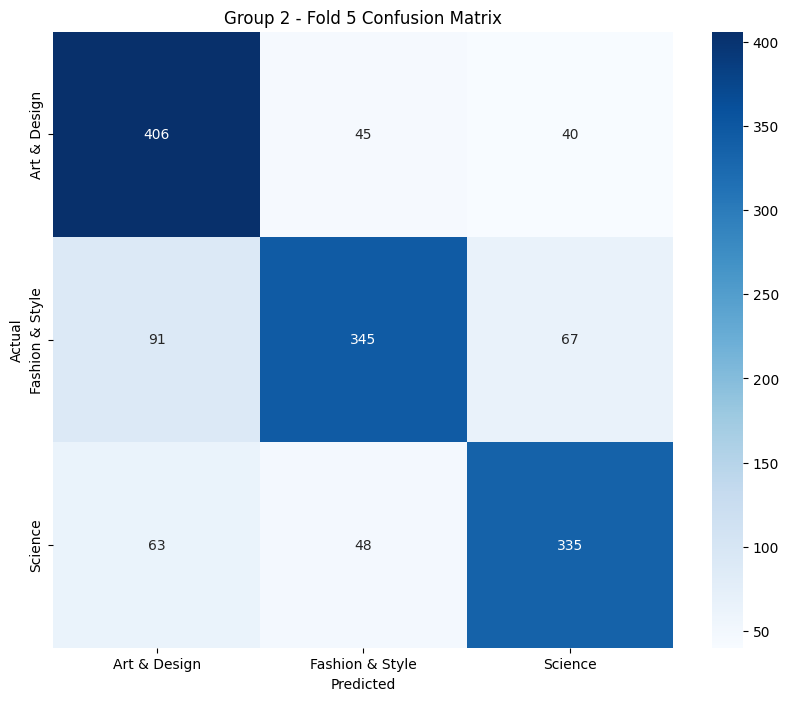


Group 3 처리 중...

  Fold 1/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1101, Test Accuracy: 0.2910
epoch 1/15: train loss 1.0999, train acc 0.3645
                         test loss 1.0796, test acc 0.4179
epoch 5/15: train loss 0.6394, train acc 0.7463
                         test loss 0.6434, test acc 0.7477
epoch 10/15: train loss 0.4768, train acc 0.8211
                         test loss 0.5758, test acc 0.7821
epoch 15/15: train loss 0.4095, train acc 0.8492
                         test loss 0.5671, test acc 0.7986
Pruning 적용 중...
Pruning 이후 성능:
  Test Loss: 0.6599, Test Accuracy: 0.7090

  Fold 2/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1296, Test Accuracy: 0.3384
epoch 1/15: train loss 1.0907, train acc 0.3851
                         test loss 1.0068, test acc 0.4746
epoch 5/15: train loss 0.6149, train acc 0.7553
                         test loss 0.6473, test acc 0.7599
epoch 10/15: train loss 0.4770, train acc 0.8148
                         test loss 0.5715, test acc 0.7785
e

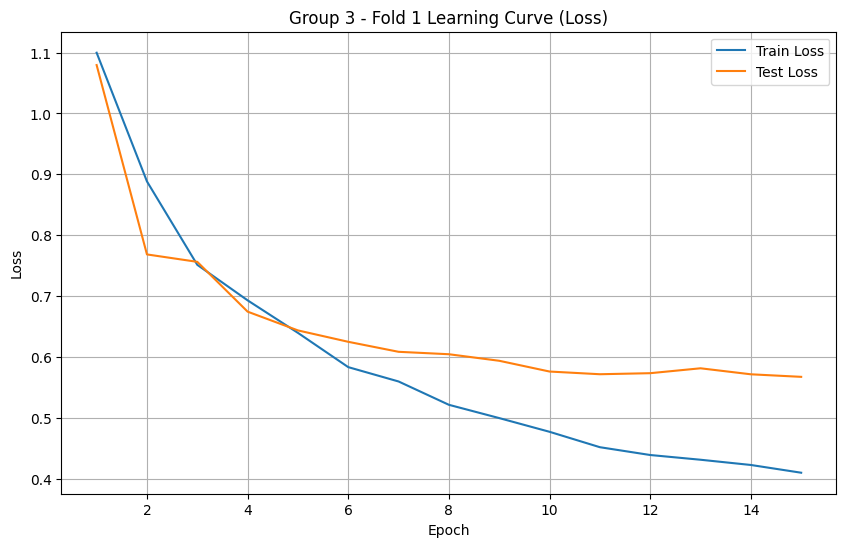

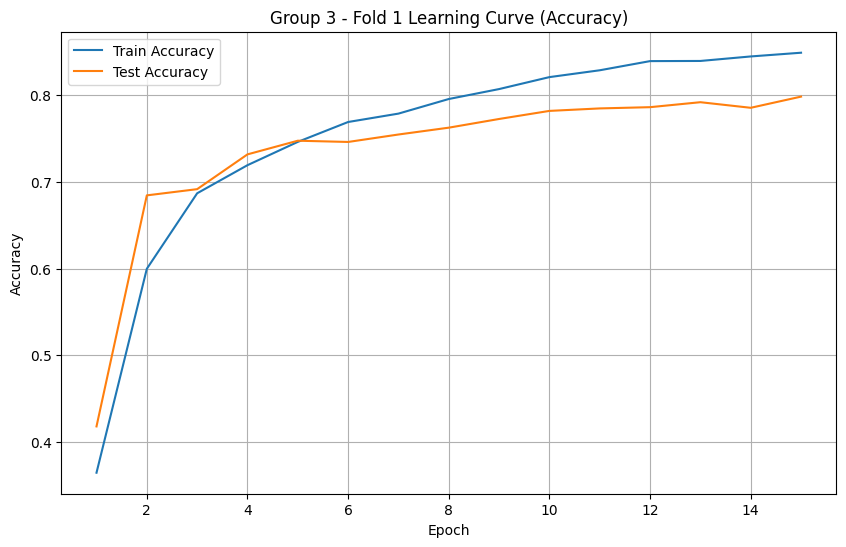

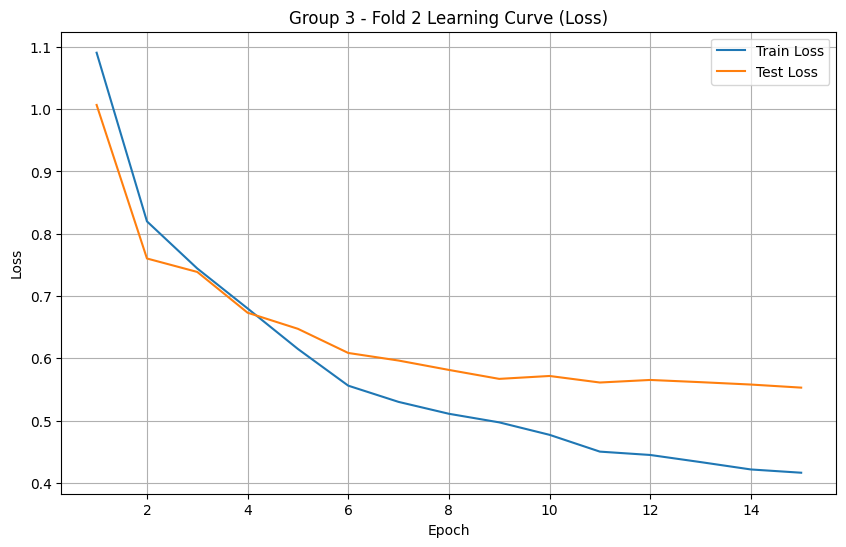

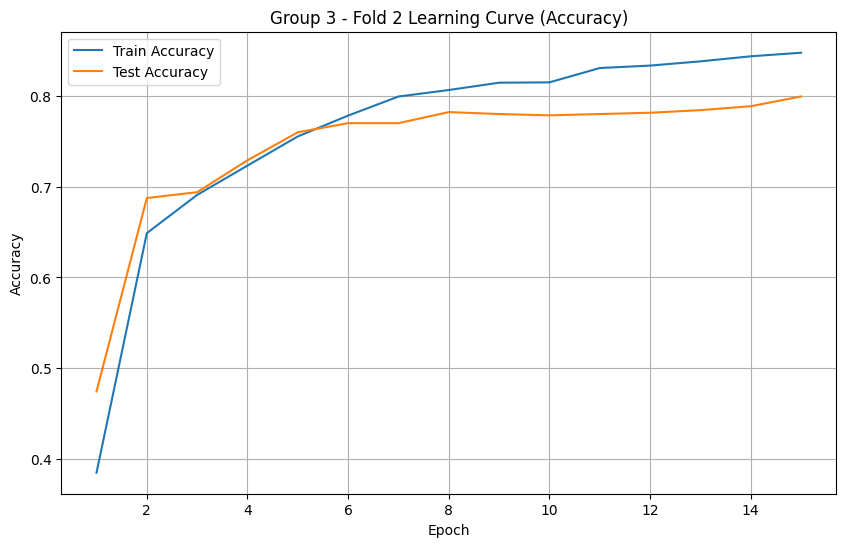

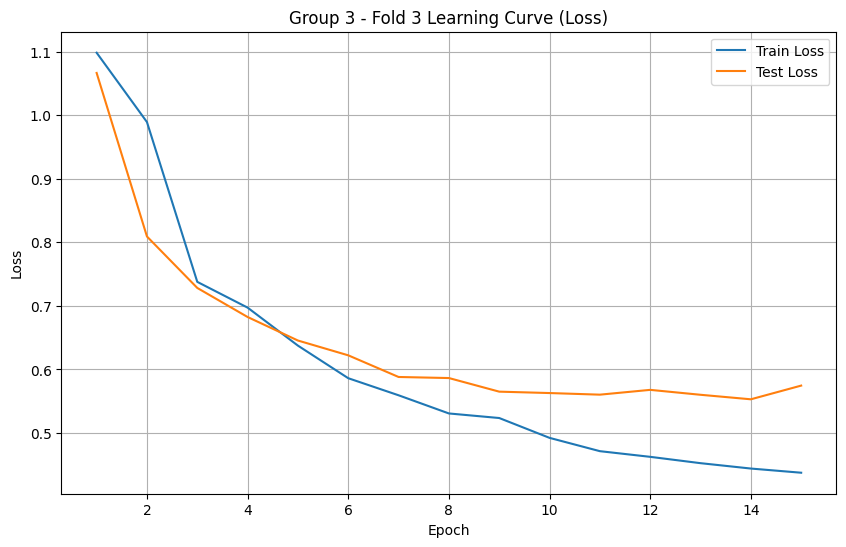

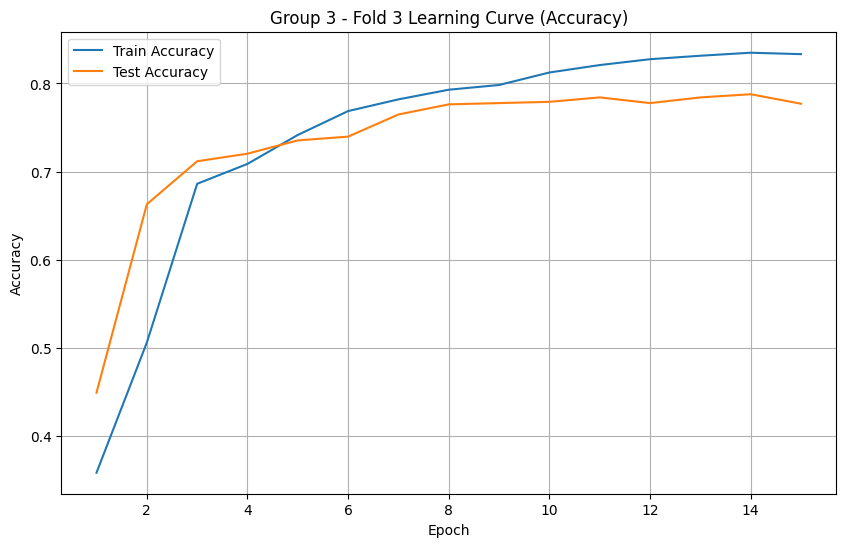

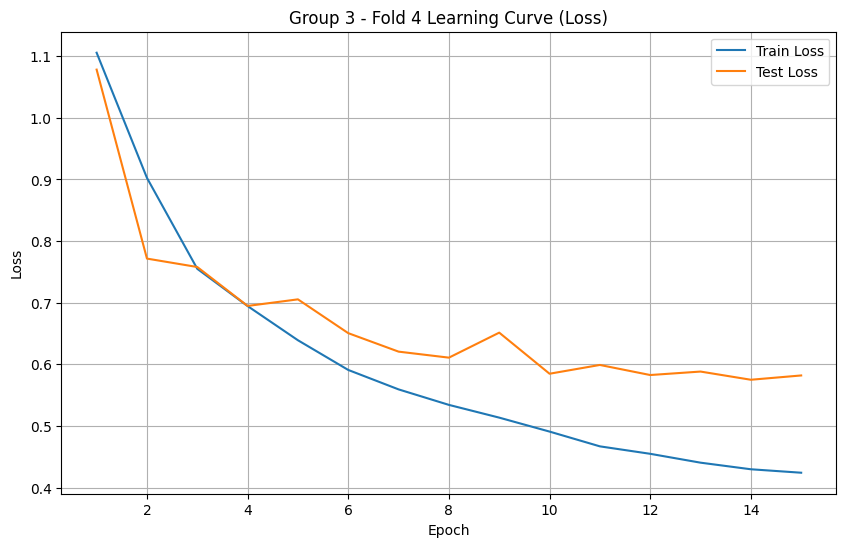

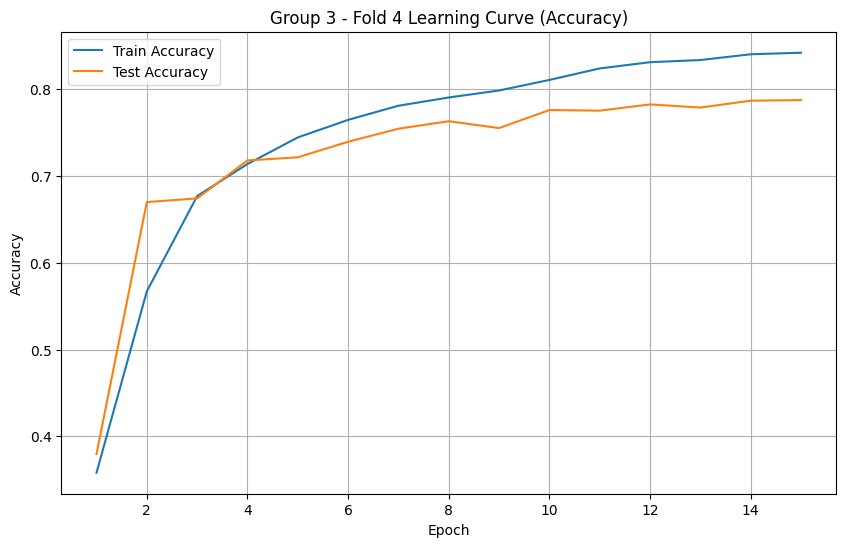

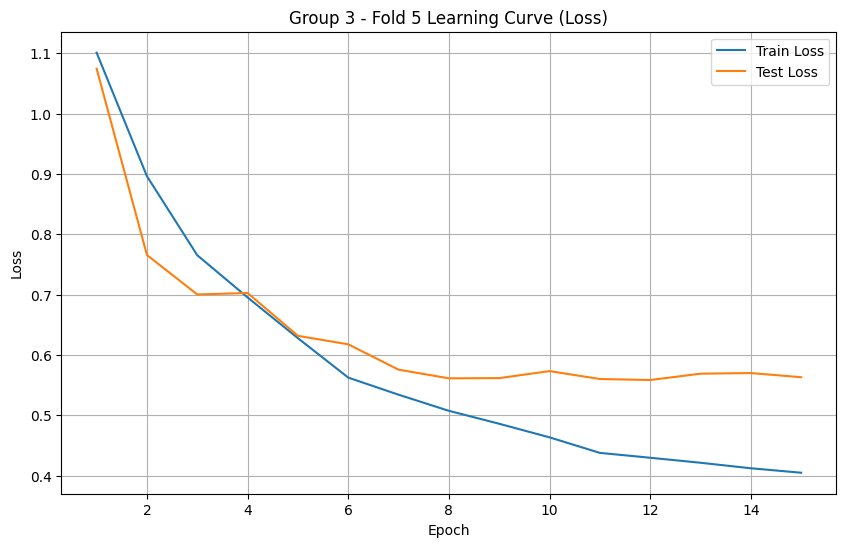

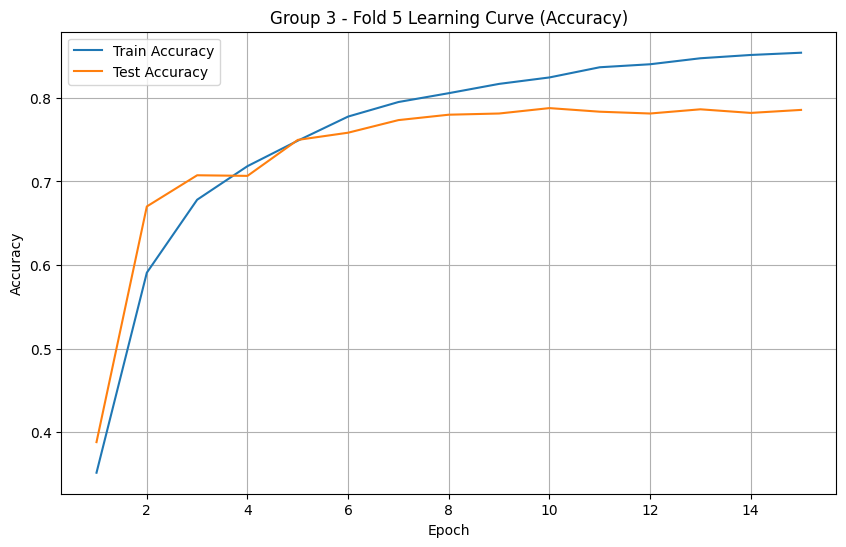

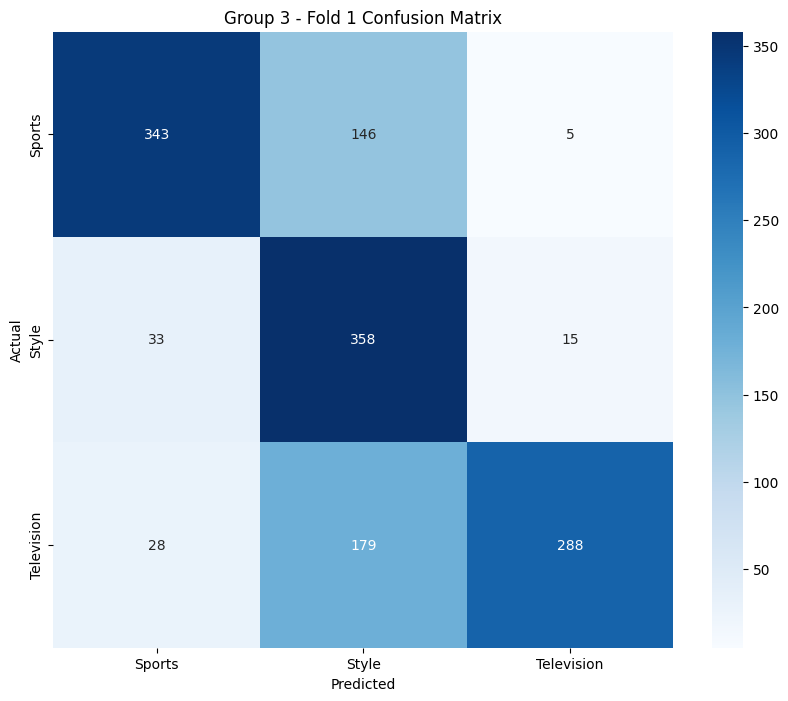

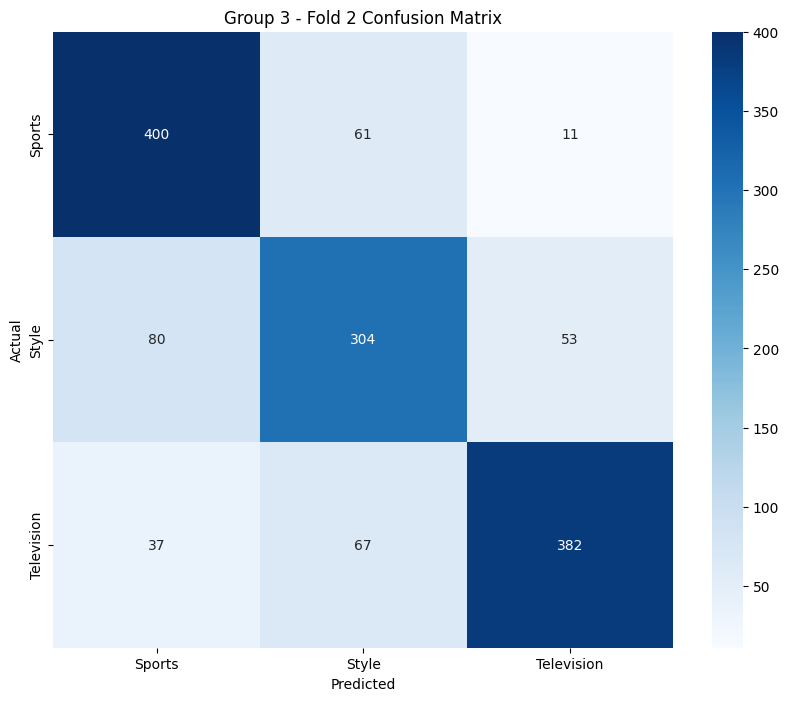

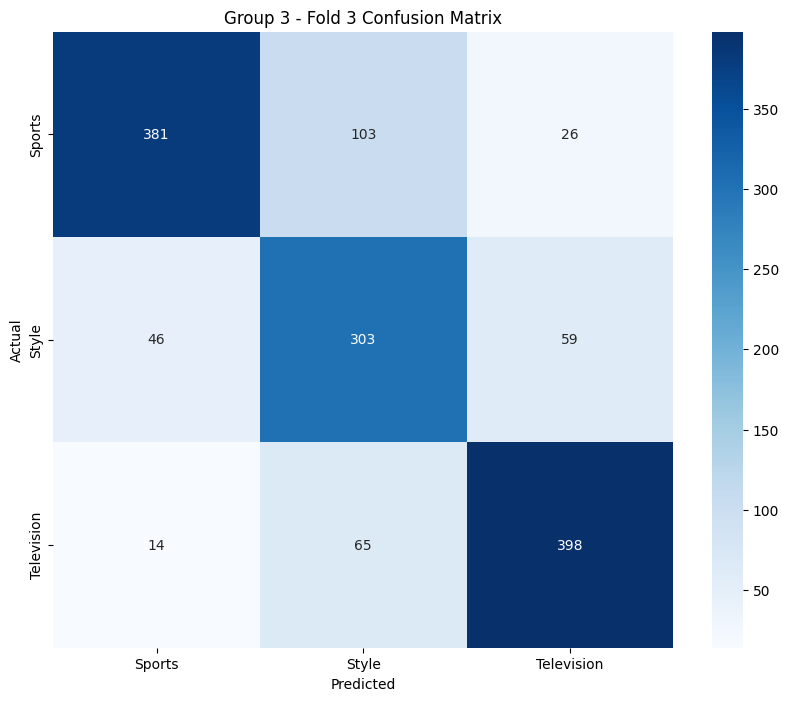

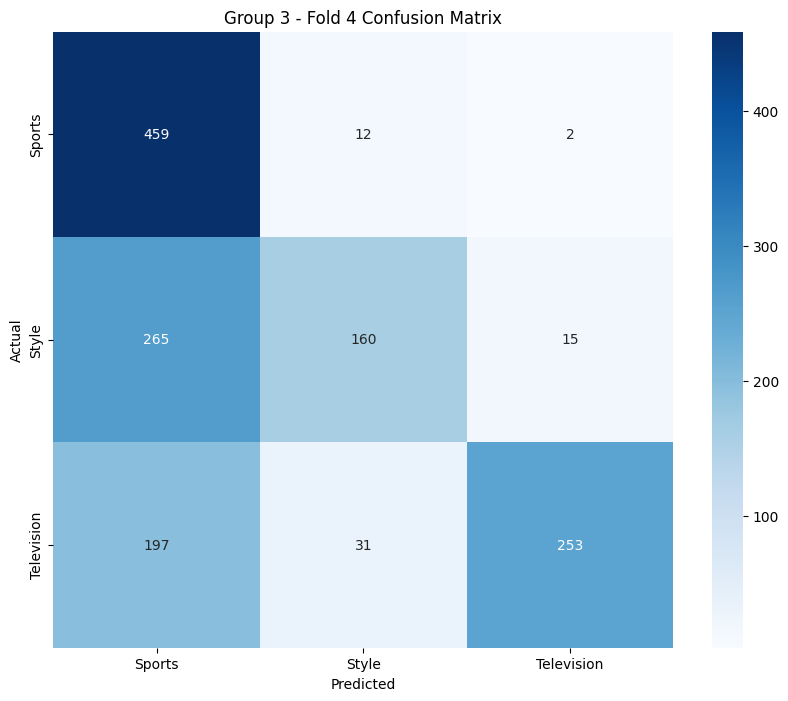

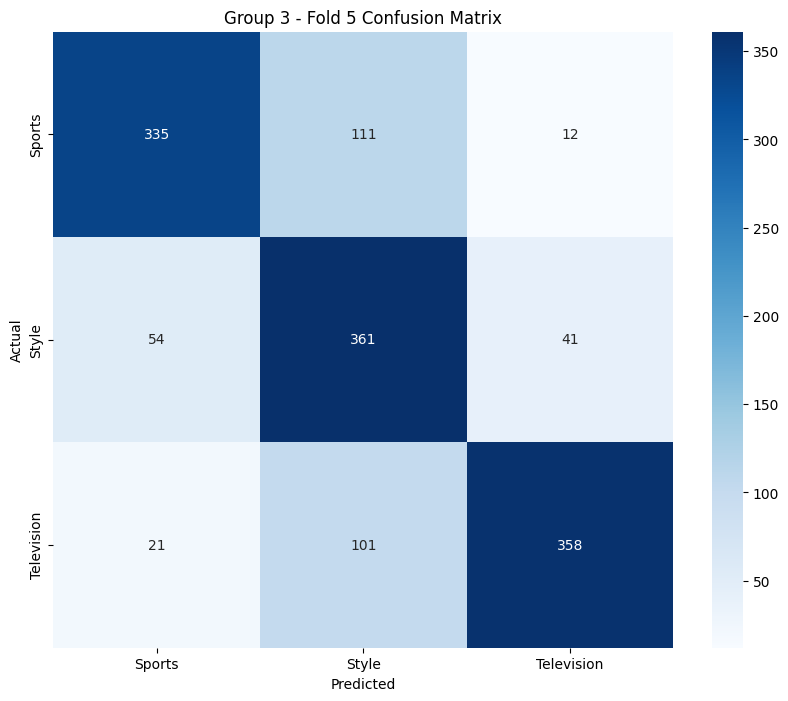


Group 4 처리 중...

  Fold 1/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1075, Test Accuracy: 0.3401
epoch 1/15: train loss 1.1103, train acc 0.3468
                         test loss 1.0947, test acc 0.3394
epoch 5/15: train loss 0.5261, train acc 0.7776
                         test loss 0.5341, test acc 0.7615
epoch 10/15: train loss 0.3439, train acc 0.8580
                         test loss 0.4161, test acc 0.8317
epoch 15/15: train loss 0.2809, train acc 0.8887
                         test loss 0.3976, test acc 0.8512
Pruning 적용 중...
Pruning 이후 성능:
  Test Loss: 0.5825, Test Accuracy: 0.7517

  Fold 2/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1094, Test Accuracy: 0.3456
epoch 1/15: train loss 1.1112, train acc 0.3348
                         test loss 1.0954, test acc 0.3574
epoch 5/15: train loss 0.5028, train acc 0.7829
                         test loss 0.5217, test acc 0.7796
epoch 10/15: train loss 0.3256, train acc 0.8736
                         test loss 0.4105, test acc 0.8373
e

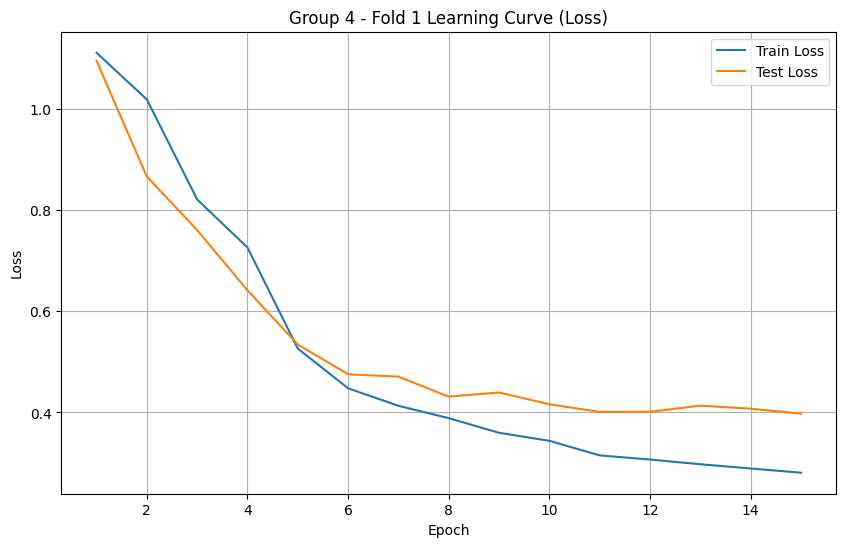

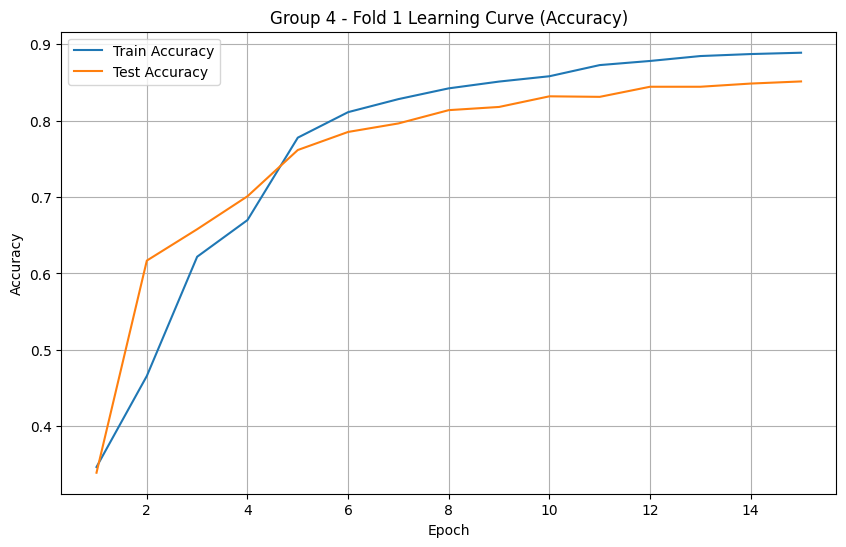

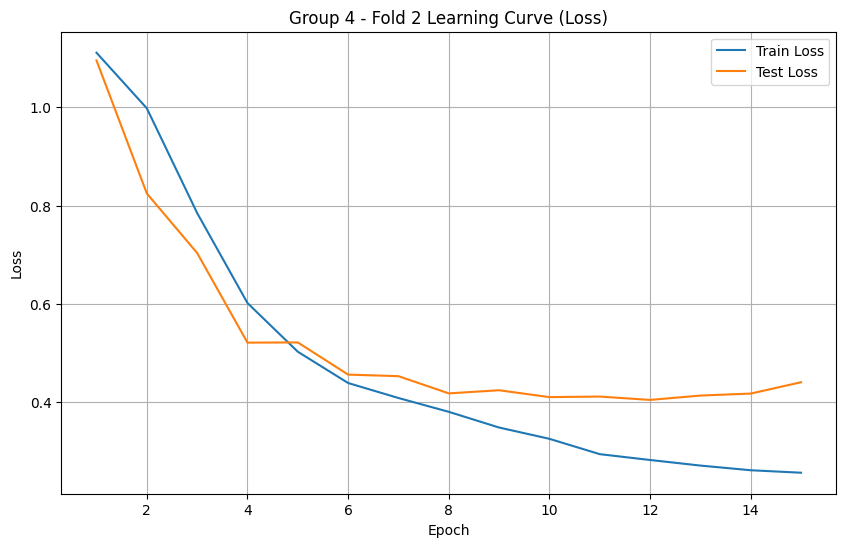

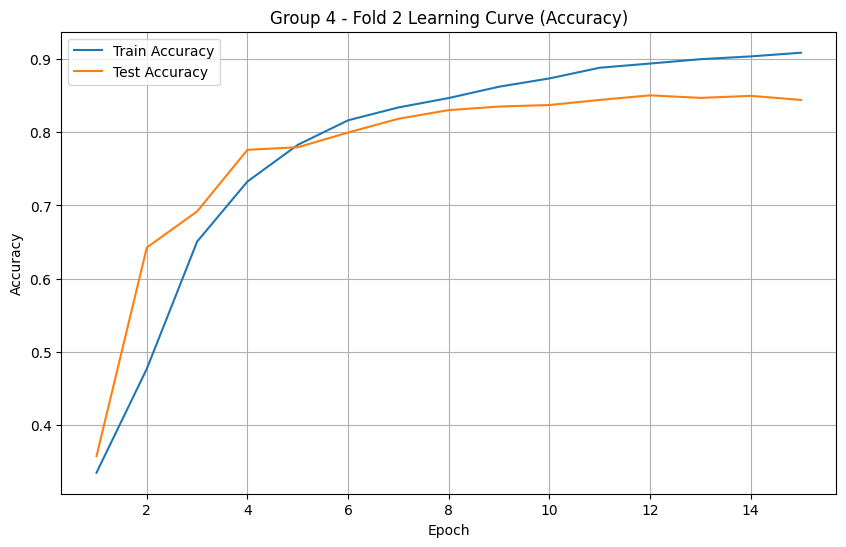

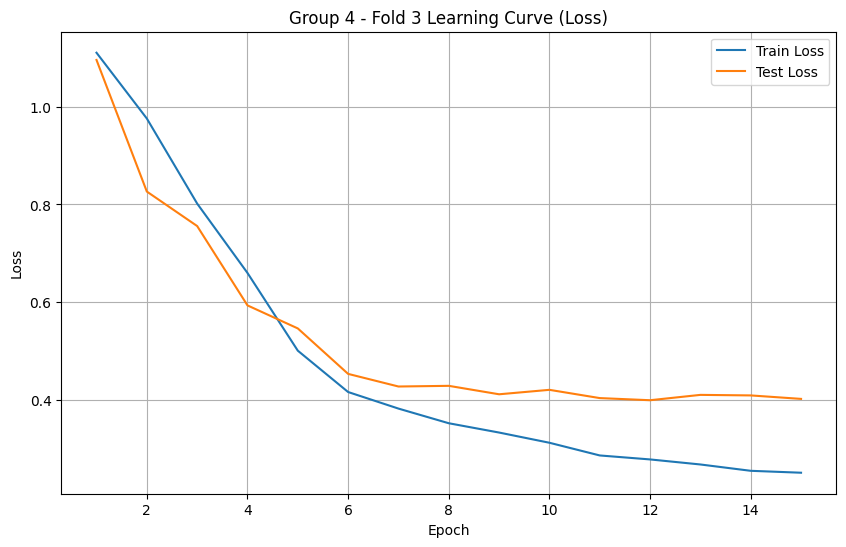

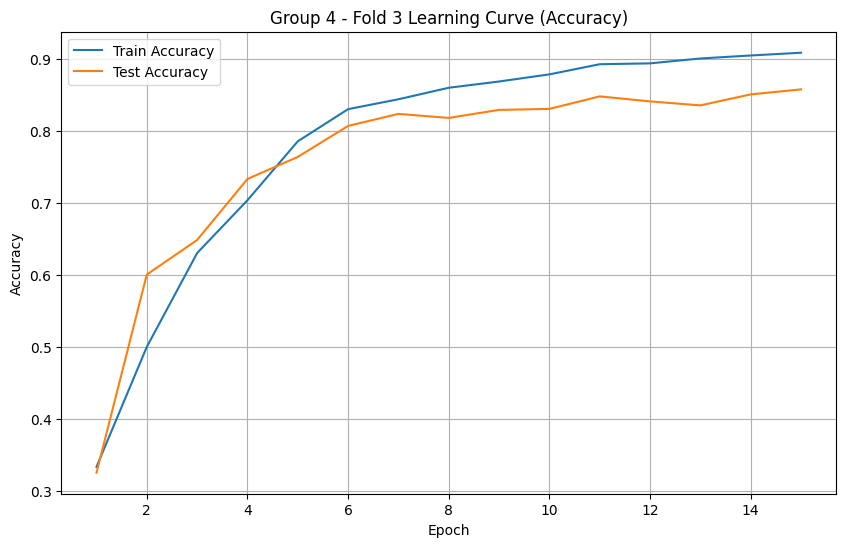

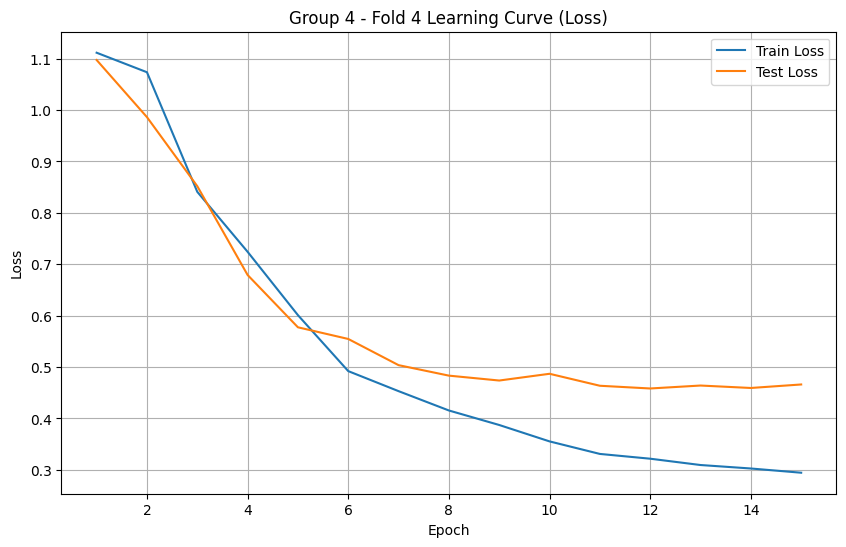

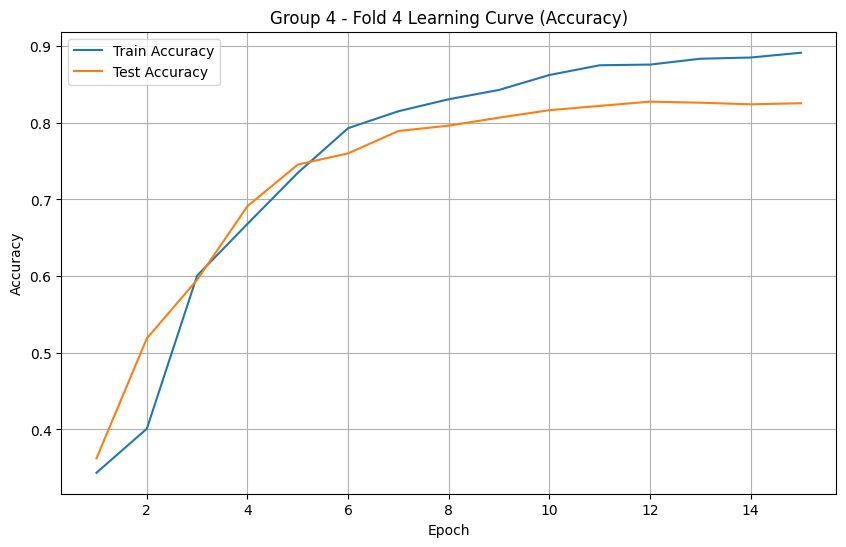

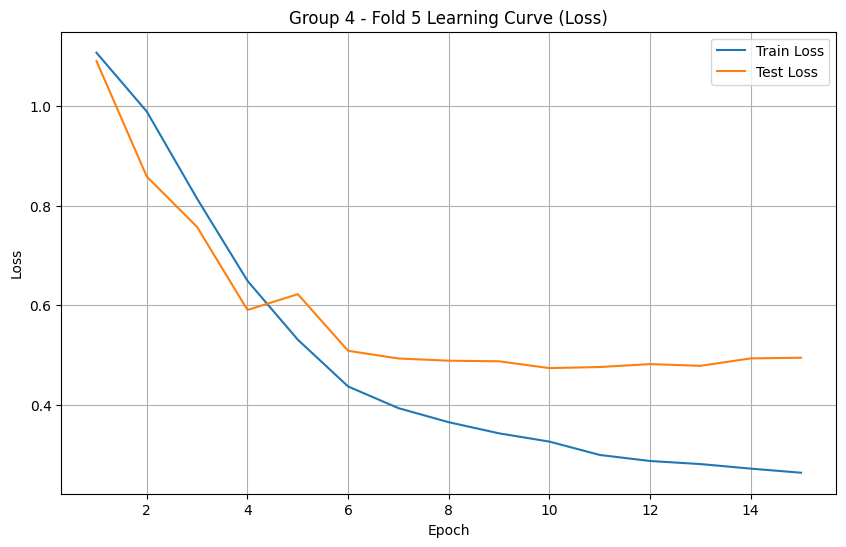

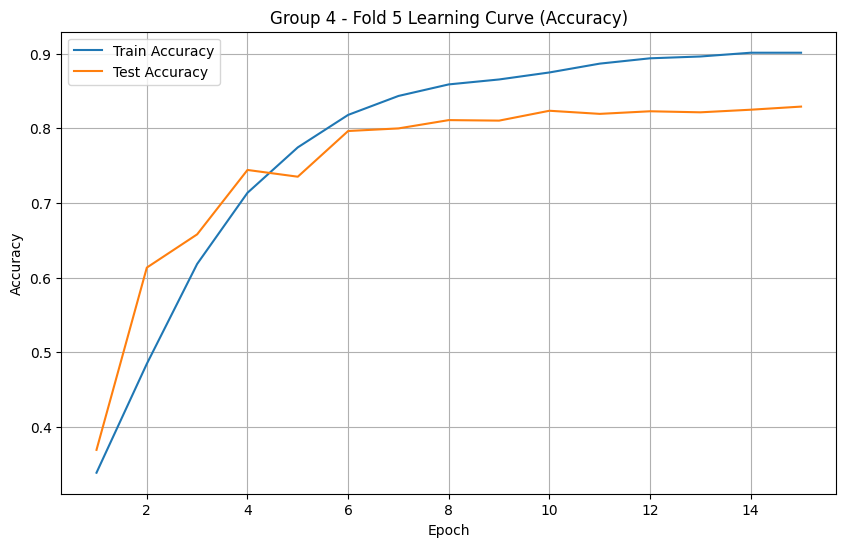

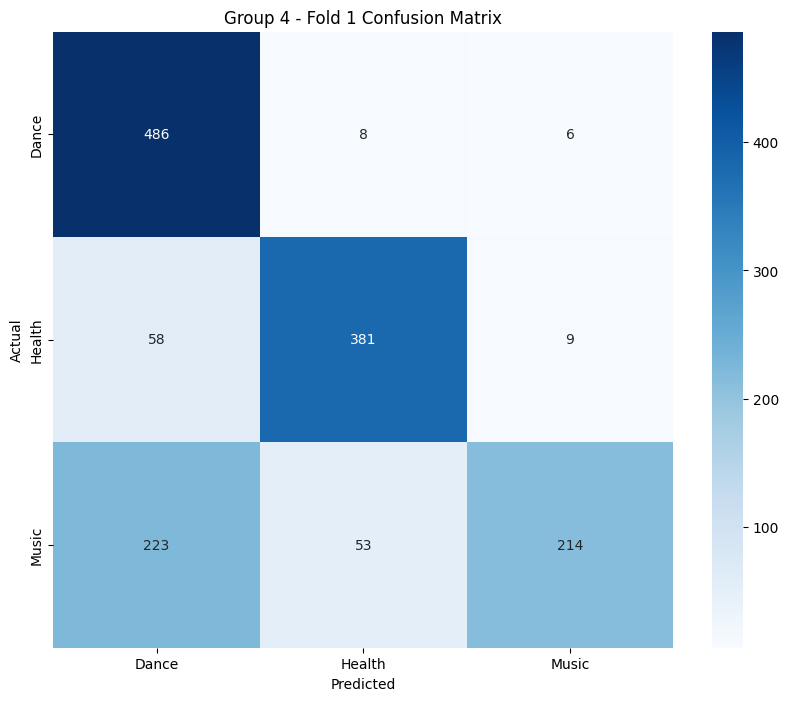

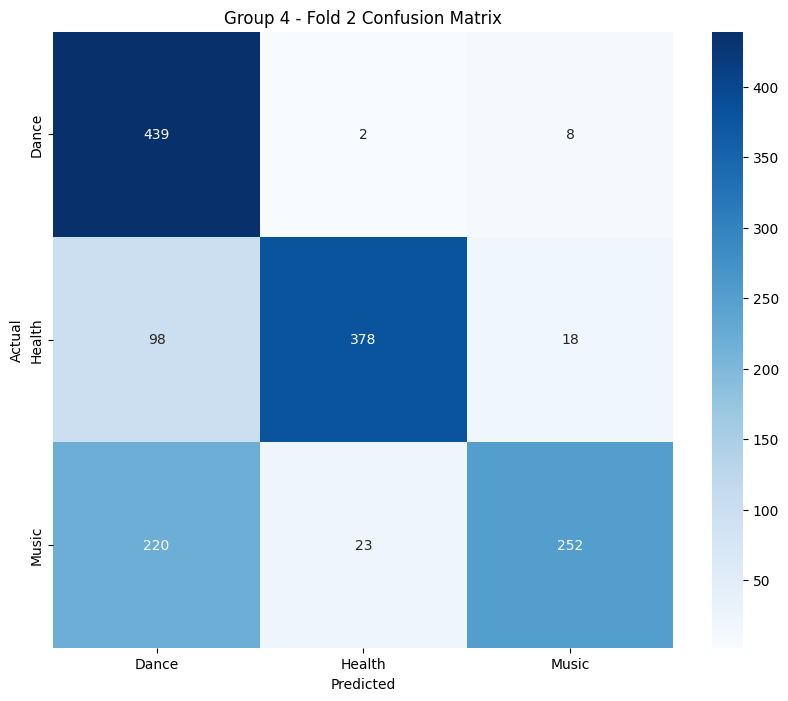

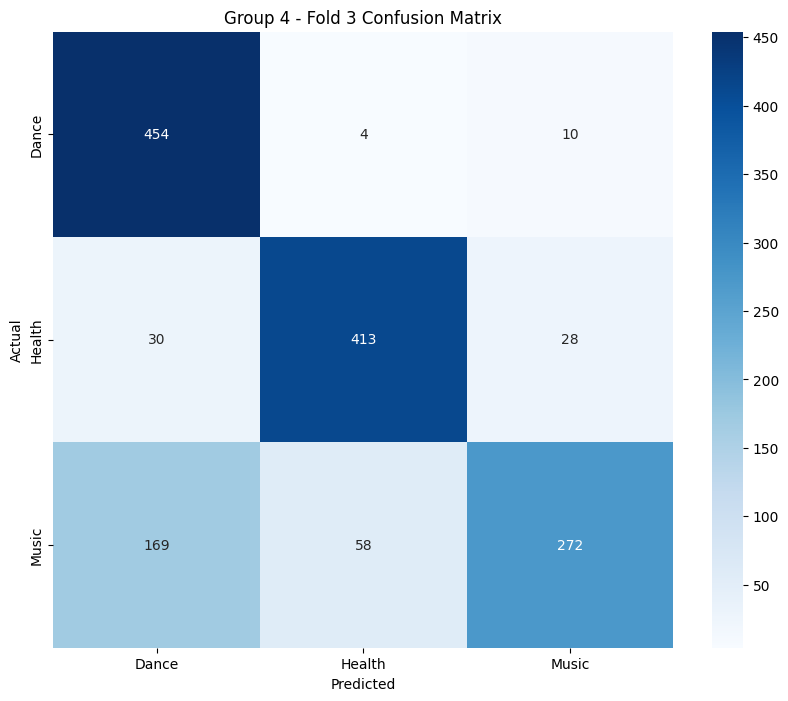

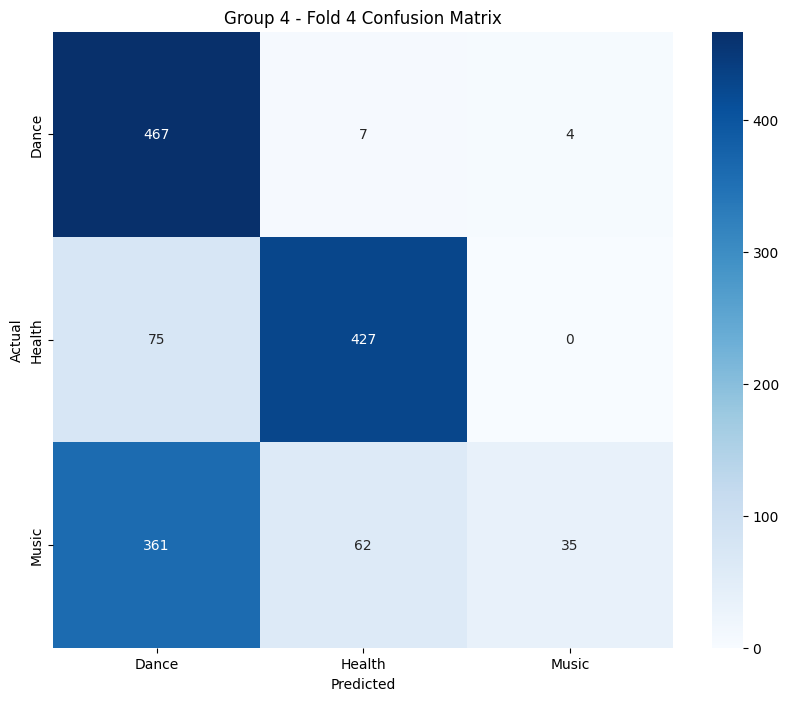

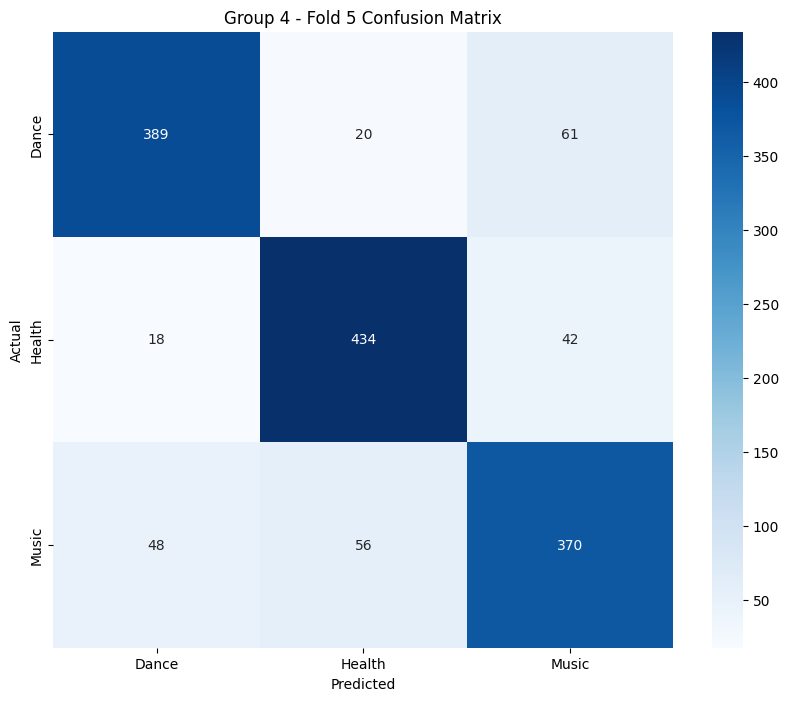


Group 5 처리 중...

  Fold 1/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1299, Test Accuracy: 0.3394
epoch 1/15: train loss 1.1055, train acc 0.3638
                         test loss 1.1074, test acc 0.3477
epoch 5/15: train loss 0.6689, train acc 0.7217
                         test loss 0.6753, test acc 0.7058
epoch 10/15: train loss 0.4650, train acc 0.8217
                         test loss 0.5843, test acc 0.7754
epoch 15/15: train loss 0.3854, train acc 0.8574
                         test loss 0.6277, test acc 0.7837
Pruning 적용 중...
Pruning 이후 성능:
  Test Loss: 0.6150, Test Accuracy: 0.7531

  Fold 2/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1277, Test Accuracy: 0.3303
epoch 1/15: train loss 1.0912, train acc 0.3760
                         test loss 1.0675, test acc 0.3818
epoch 5/15: train loss 0.6430, train acc 0.7292
                         test loss 0.6706, test acc 0.7017
epoch 10/15: train loss 0.5040, train acc 0.7953
                         test loss 0.6269, test acc 0.7448
e

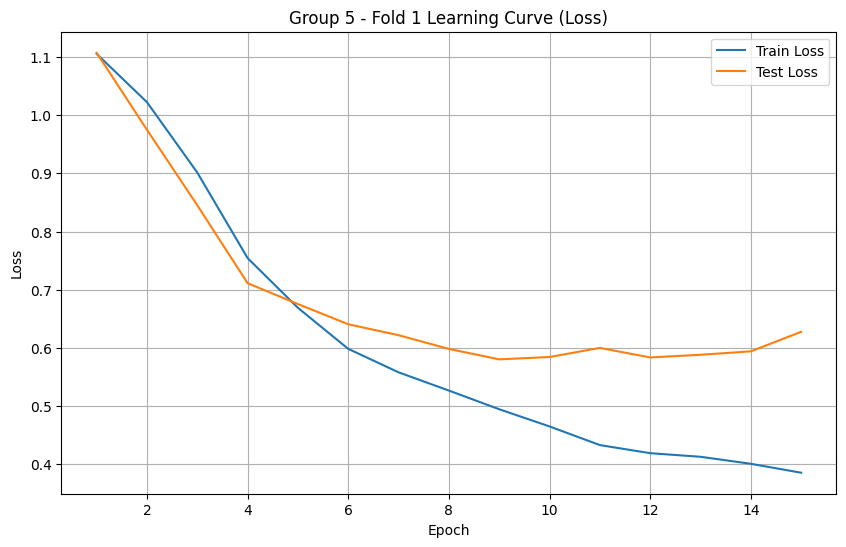

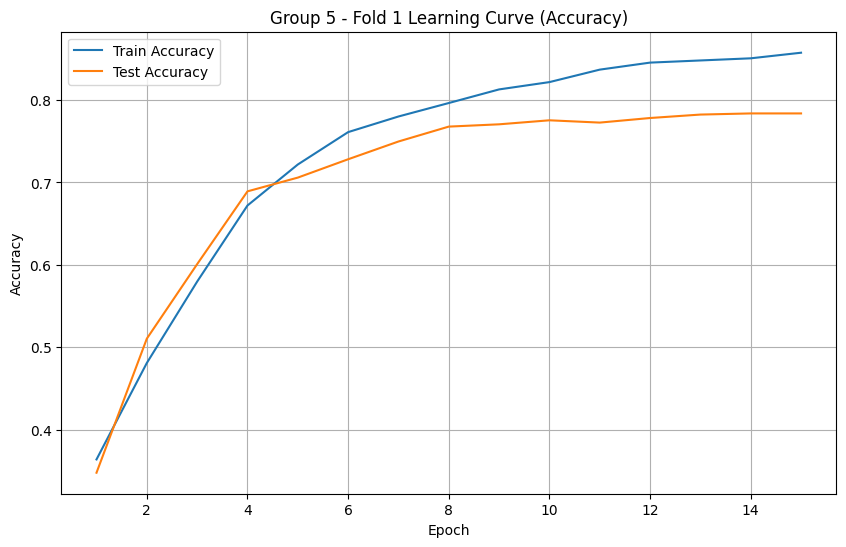

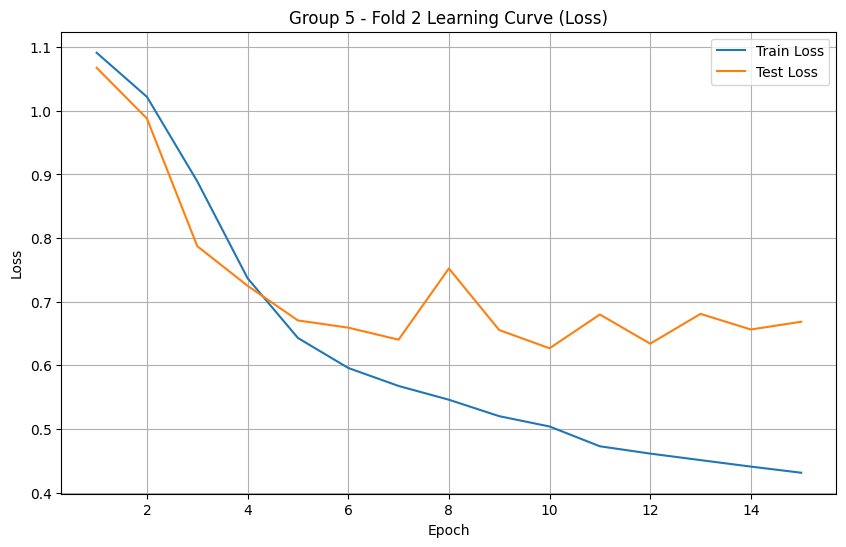

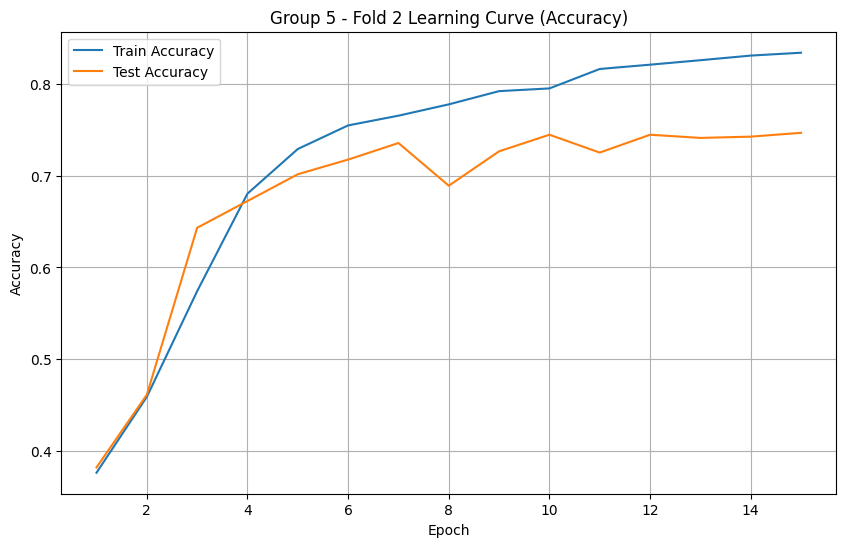

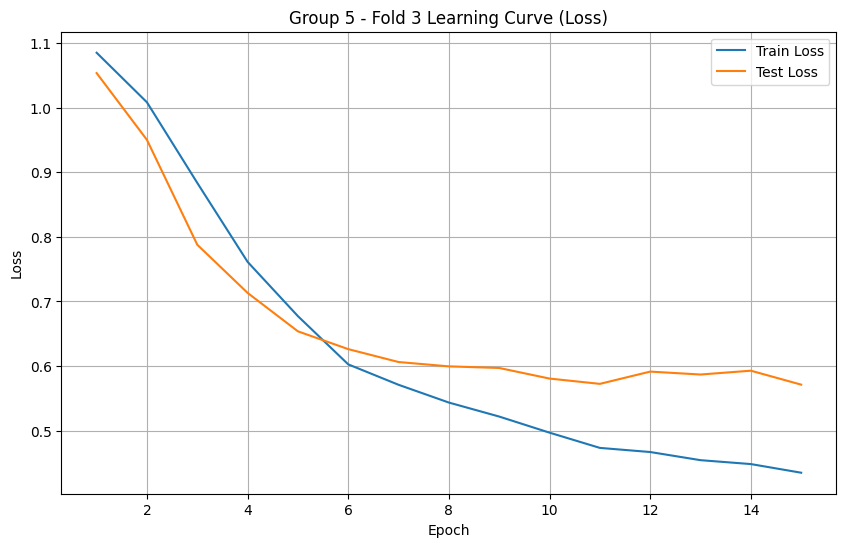

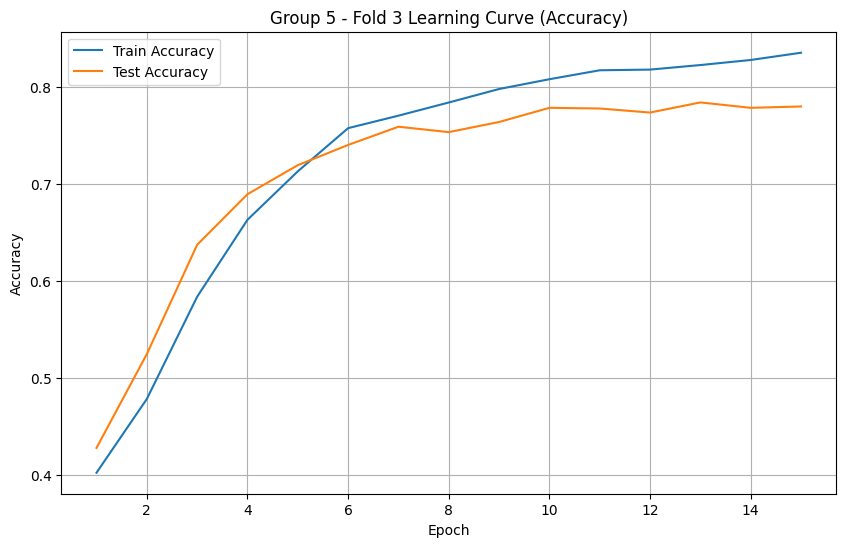

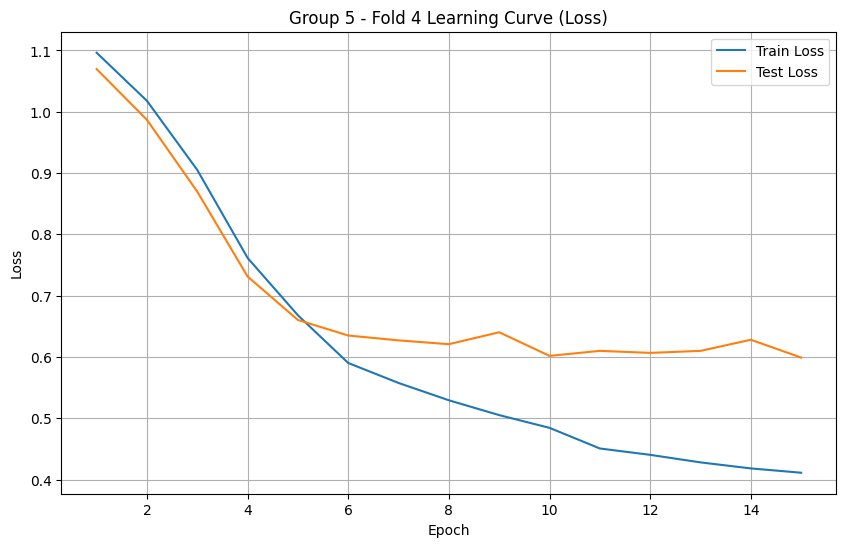

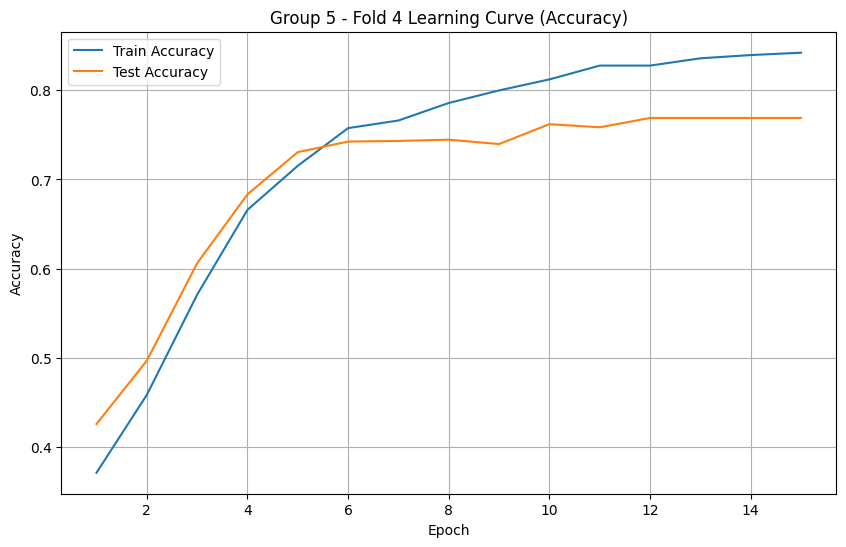

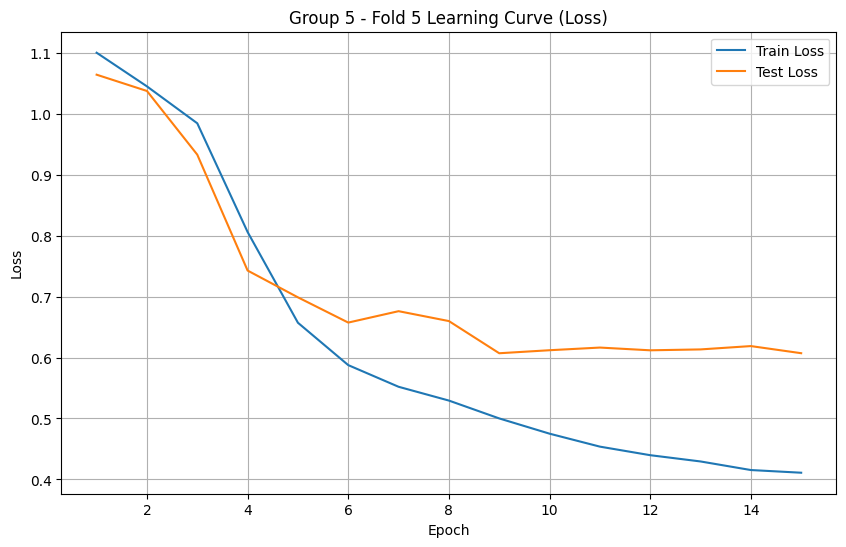

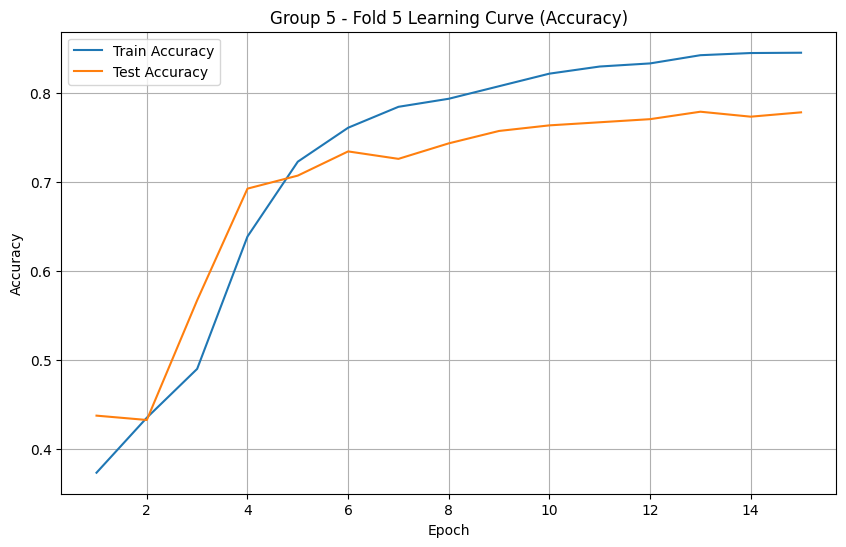

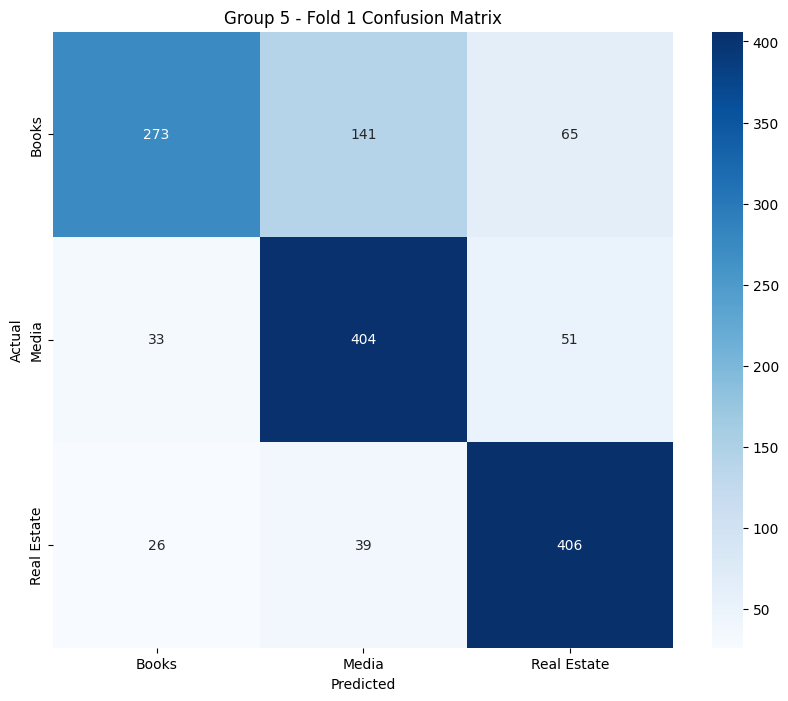

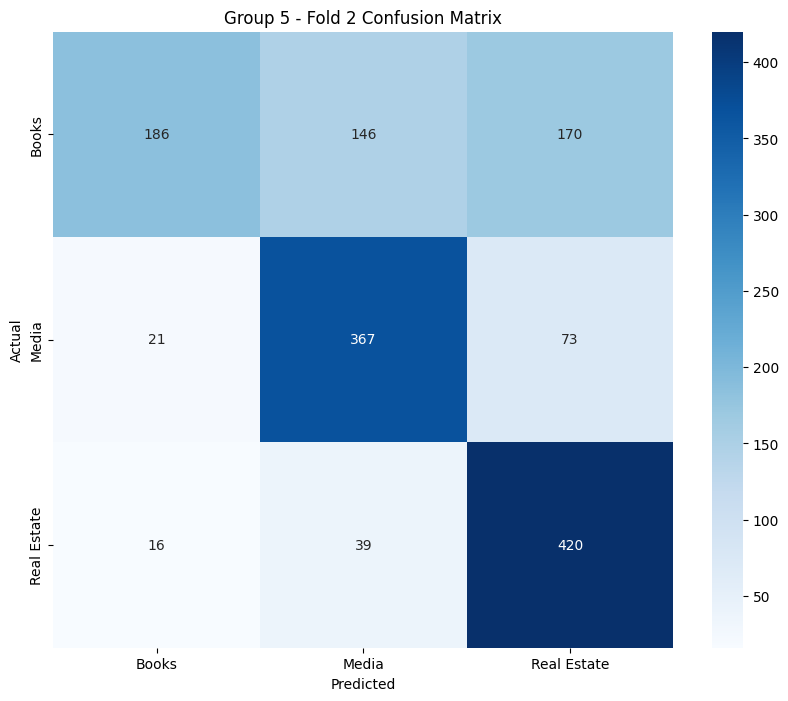

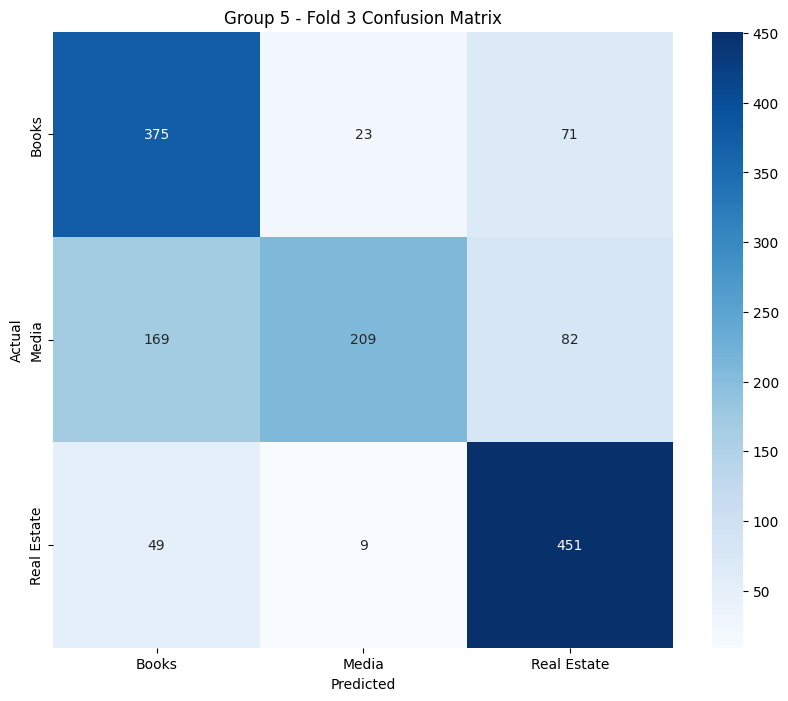

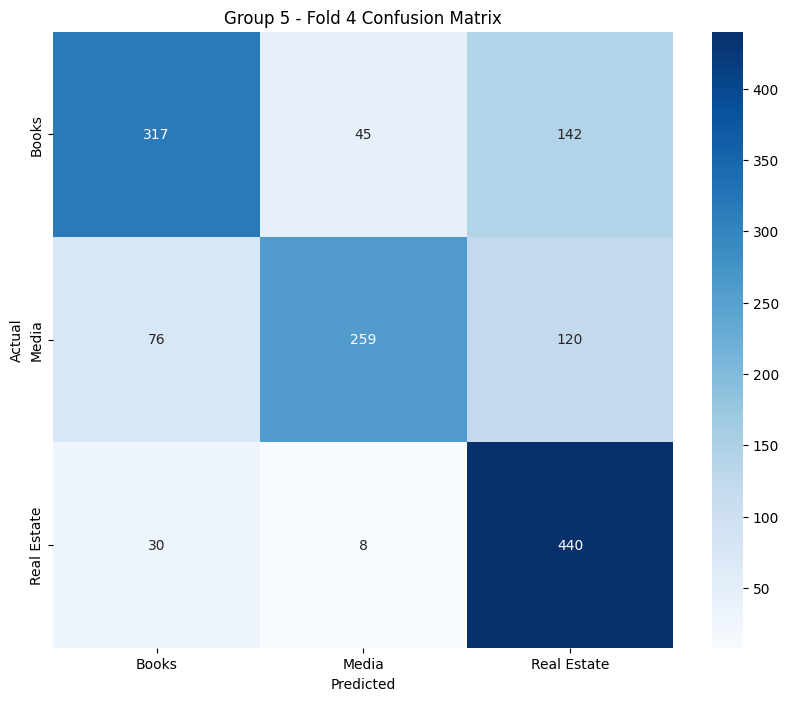

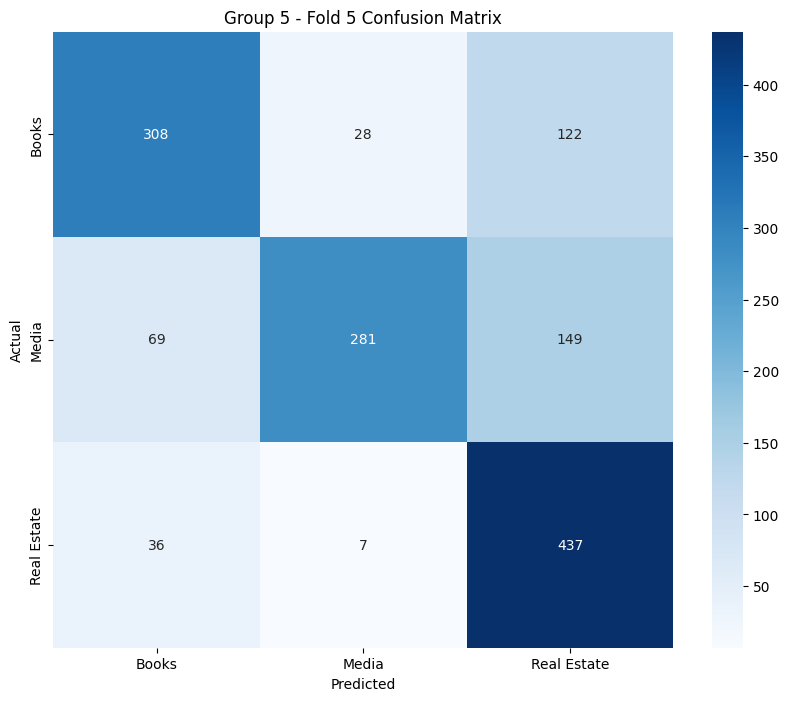


Group 6 처리 중...

  Fold 1/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1168, Test Accuracy: 0.3347
epoch 1/15: train loss 1.0288, train acc 0.4630
                         test loss 0.8363, test acc 0.6326
epoch 5/15: train loss 0.4562, train acc 0.8255
                         test loss 0.4663, test acc 0.8243
epoch 10/15: train loss 0.3354, train acc 0.8779
                         test loss 0.4378, test acc 0.8389
epoch 15/15: train loss 0.2882, train acc 0.8986
                         test loss 0.4616, test acc 0.8410
Pruning 적용 중...
Pruning 이후 성능:
  Test Loss: 0.5355, Test Accuracy: 0.7847

  Fold 2/5 처리 중...
Pruning 이전 성능:
  Test Loss: 1.1106, Test Accuracy: 0.3444
epoch 1/15: train loss 1.0678, train acc 0.4083
                         test loss 1.0114, test acc 0.4840
epoch 5/15: train loss 0.5277, train acc 0.7963
                         test loss 0.4698, test acc 0.8326
epoch 10/15: train loss 0.3689, train acc 0.8635
                         test loss 0.4359, test acc 0.8354
e

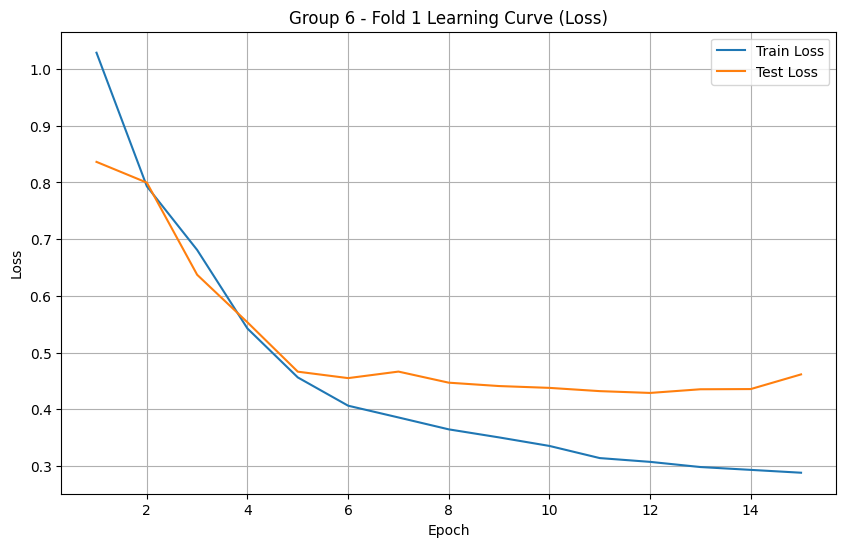

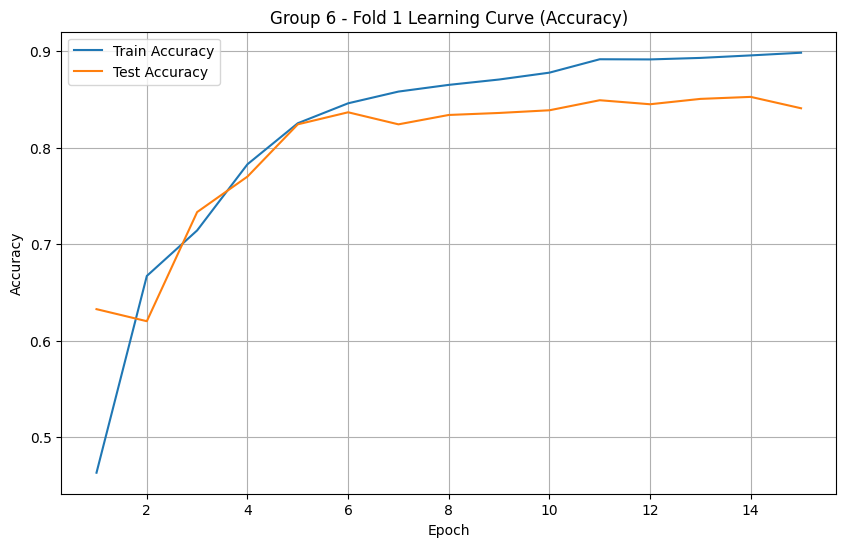

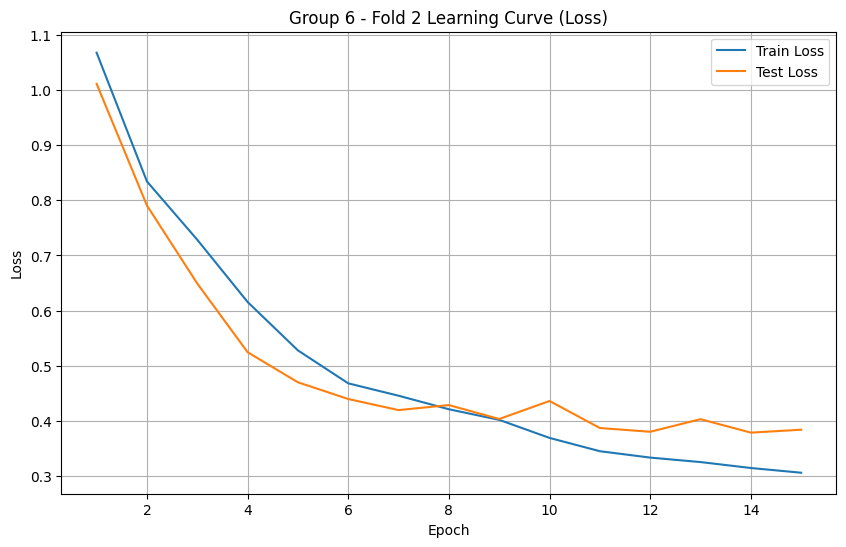

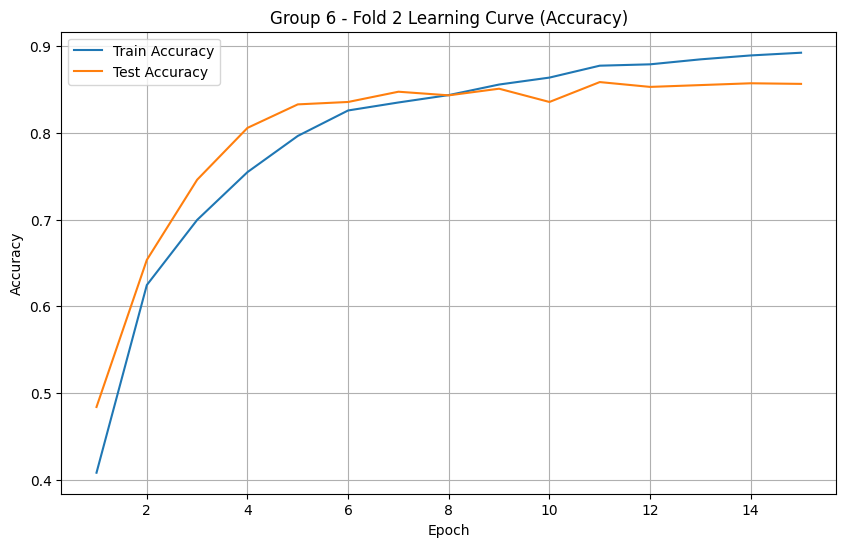

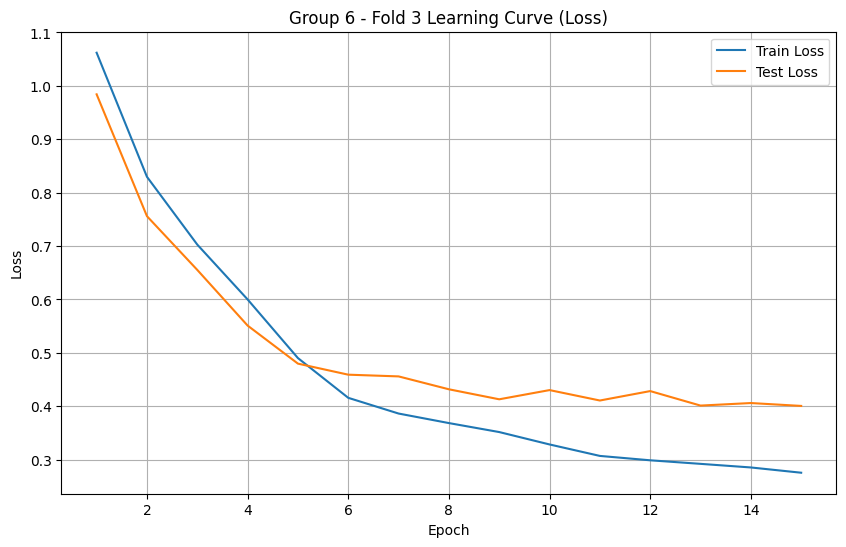

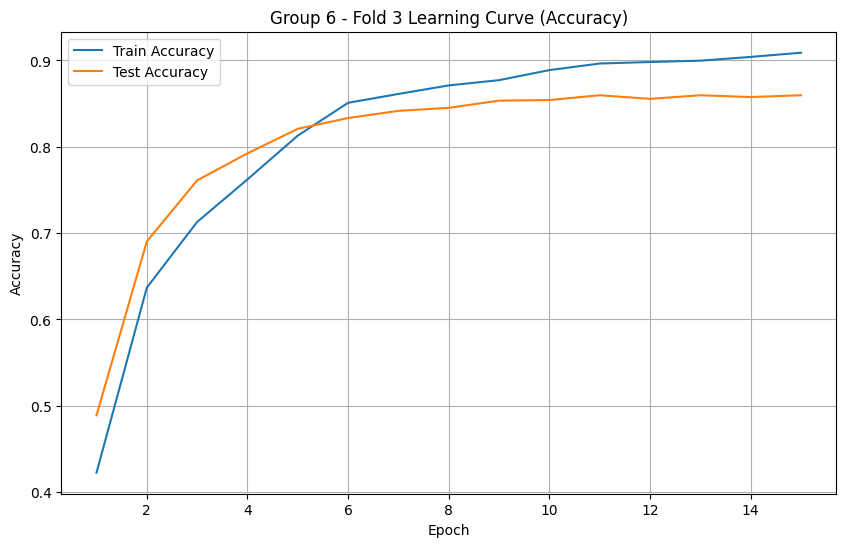

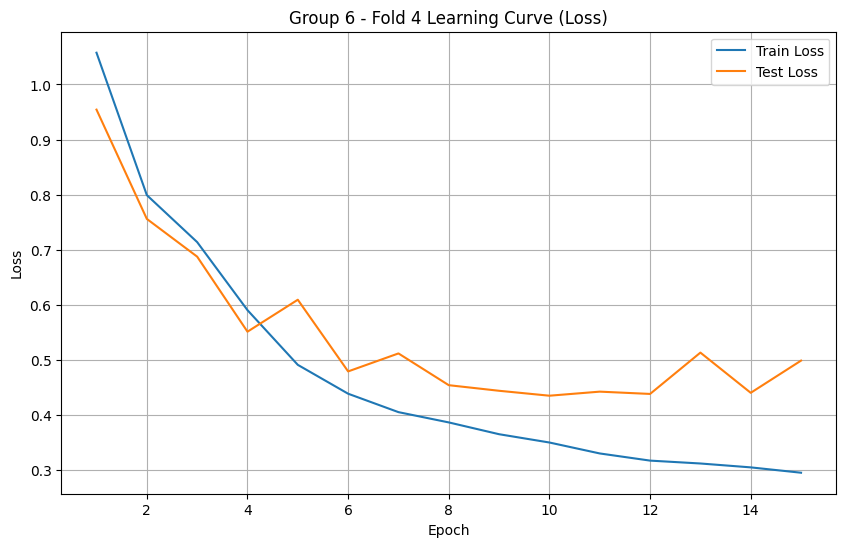

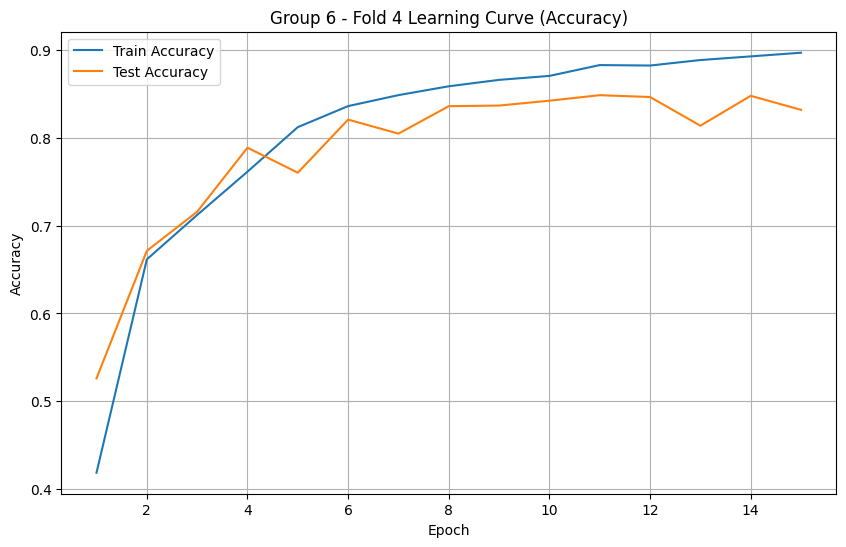

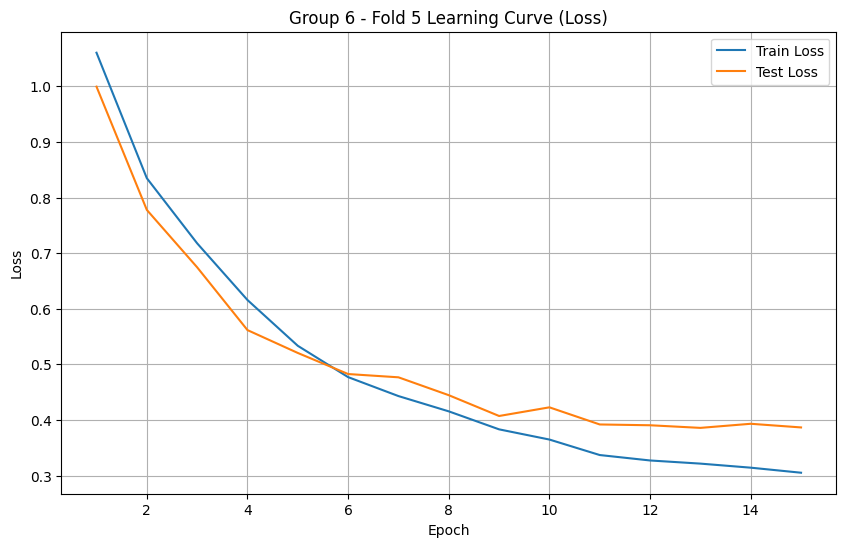

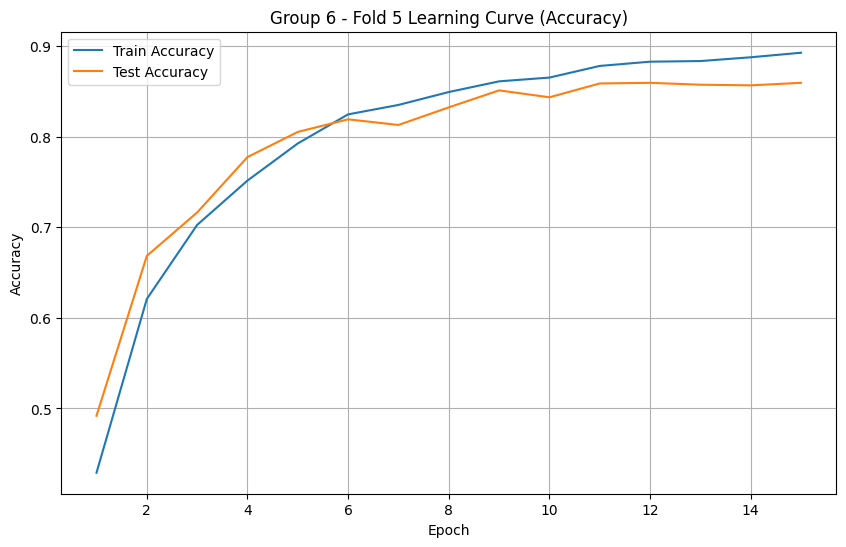

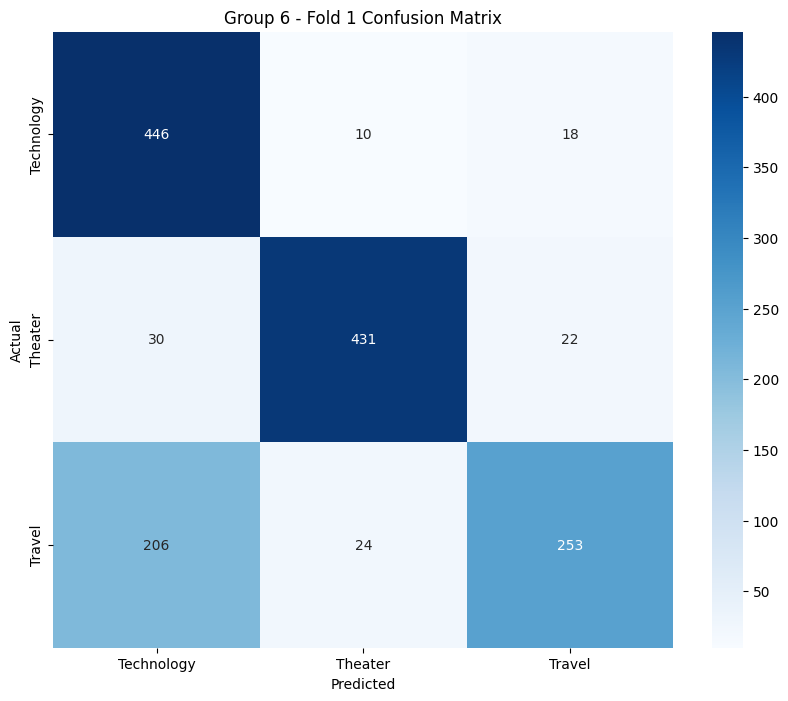

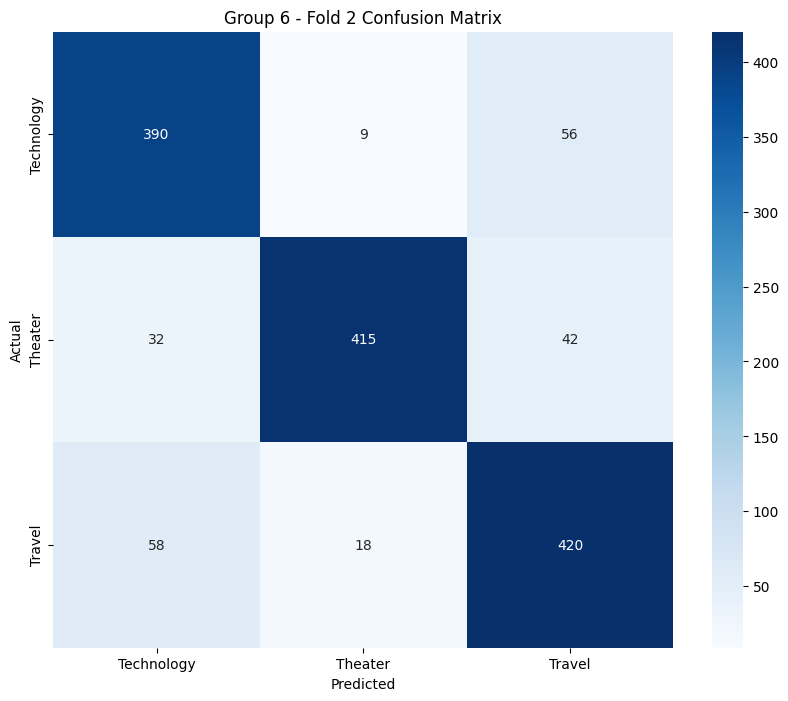

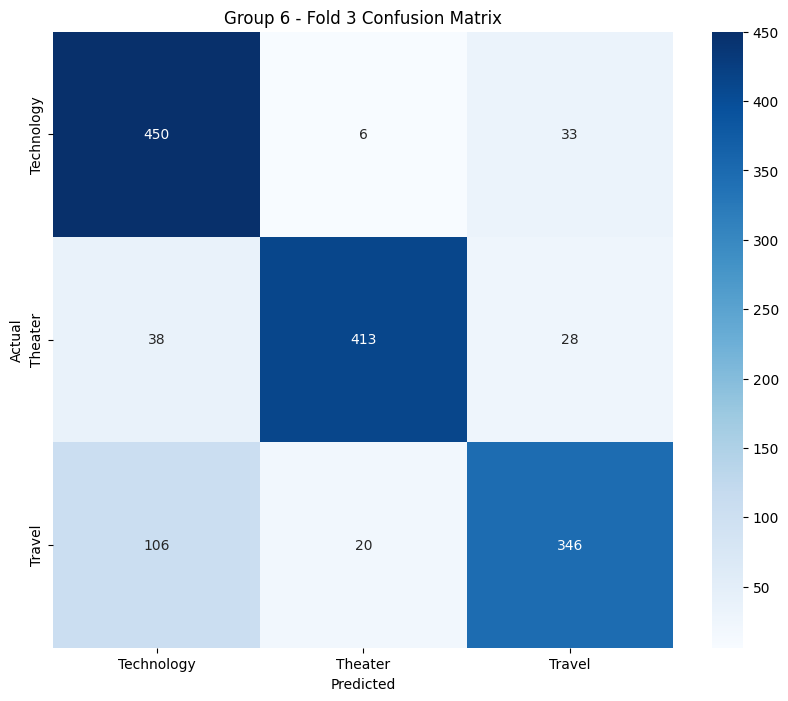

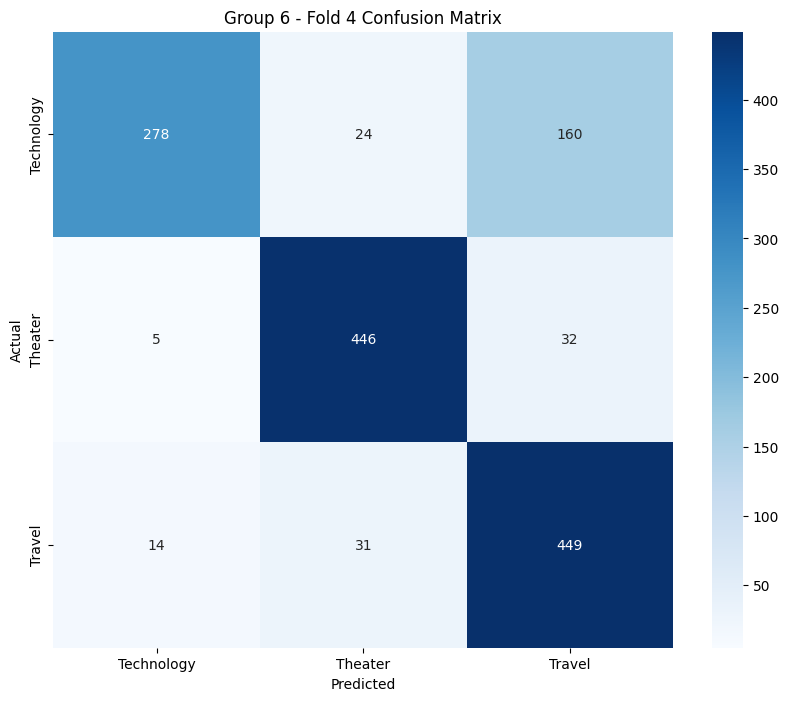

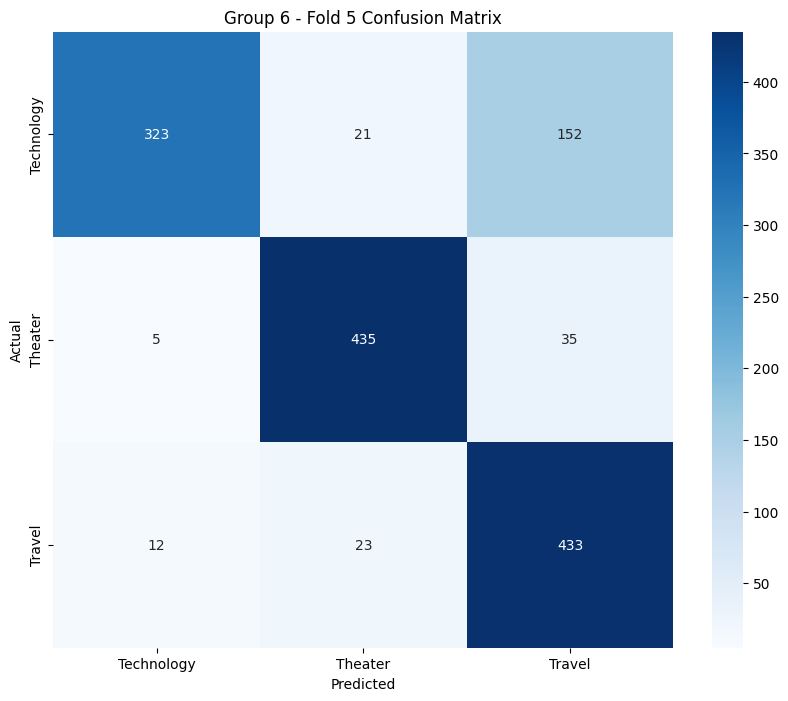

In [9]:
results = []
all_learning_curves = []



for idx, group_file in enumerate(output_paths, start=1):
    print(f"\nGroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids = tokenize_data(df)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, labels)
    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_results = []
    fold_learning_curves = []

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset), start=1):
        print(f"\n  Fold {fold}/{K_FOLDS} 처리 중...")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

        # Perceiver 모델 초기화
        perceiver = Perceiver(
            input_dim=EMBED_DIM,          
            latent_dim=LATENT_DIM,
            latent_size=LATENT_SIZE,
            num_classes=num_classes,
            num_blocks=NUM_BLOCKS,
            self_attn_layers_per_block=1
        )

        # CombinedModel 초기화
        combined_model = CombinedModel(
            vocab_size=tokenizer.vocab_size,
            embed_dim=EMBED_DIM,
            perceiver_model=perceiver
        )

        # PackNet 
        packnet_model = PackNet(combined_model)
        packnet_model.to(device)

        packnet_model.set_task(f"task_{idx}_{fold}")

      
        optimizer = optim.Adam(packnet_model.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        criterion = nn.CrossEntropyLoss()

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        # Pruning 이전 성능 평가
        print("Pruning 이전 성능:")
        initial_test_loss, initial_test_acc = eval_epoch(packnet_model, test_loader, criterion, device)
        print(f"  Test Loss: {initial_test_loss:.4f}, Test Accuracy: {initial_test_acc:.4f}")

        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(packnet_model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = eval_epoch(packnet_model, test_loader, criterion, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            scheduler.step()

            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"epoch {epoch+1}/{EPOCHS}: train loss {train_loss:.4f}, train acc {train_acc:.4f}")
                print(f"                         test loss {test_loss:.4f}, test acc {test_acc:.4f}")

        # Pruning 적용
        print("Pruning 적용 중...")
        packnet_model.prune(sparsity=0.2)

        # Pruning 이후 성능 평가
        print("Pruning 이후 성능:")
        pruned_test_loss, pruned_test_acc = eval_epoch(packnet_model, test_loader, criterion, device)
        print(f"  Test Loss: {pruned_test_loss:.4f}, Test Accuracy: {pruned_test_acc:.4f}")

        # learning curve
        fold_learning_curves.append({
            "Fold": fold,
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies
        })

        # confusion matrix
        y_true, y_pred = [], []
        packnet_model.eval()
        with torch.no_grad():
            for batch in test_loader:
                input_ids_batch = batch['input_ids'].to(device)
                labels_batch = batch['labels'].to(device)

                outputs = packnet_model(input_ids_batch)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels_batch.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)
        fold_results.append({
            "Fold": fold,
            "Test Accuracy": pruned_test_acc,
            "Confusion Matrix": cm,
            "Classification Report": report
        })

    
    avg_accuracy = np.mean([fr["Test Accuracy"] for fr in fold_results])
    results.append({
        "Group": idx,
        "Average Test Accuracy": avg_accuracy,
        "Fold Results": fold_results
    })

    all_learning_curves.append({
        "Group": idx,
        "Fold Learning Curves": fold_learning_curves
    })

    print(f"\n그룹 {idx}의 {K_FOLDS} 폴드 평균 테스트 정확도: {avg_accuracy:.4f}")

    
    for fold_result in fold_results:
        print(f"\n  폴드 {fold_result['Fold']} 결과:")
        print(f"    테스트 정확도: {fold_result['Test Accuracy']:.4f}")
        print(pd.DataFrame(fold_result['Classification Report']).transpose())

   
    for curve in fold_learning_curves:
        fold_idx = curve["Fold"]

      
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="Train Loss")
        plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="Test Loss")
        plt.title(f"Group {idx} - Fold {fold_idx} Learning Curve (Loss)")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="Train Accuracy")
        plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="Test Accuracy")
        plt.title(f"Group {idx} - Fold {fold_idx} Learning Curve (Accuracy)")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

    for fold_result in fold_results:
        fold_idx = fold_result["Fold"]
        cm = fold_result["Confusion Matrix"]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, 
                    yticklabels=label_encoder.classes_)
        plt.title(f"Group {idx} - Fold {fold_idx} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()
